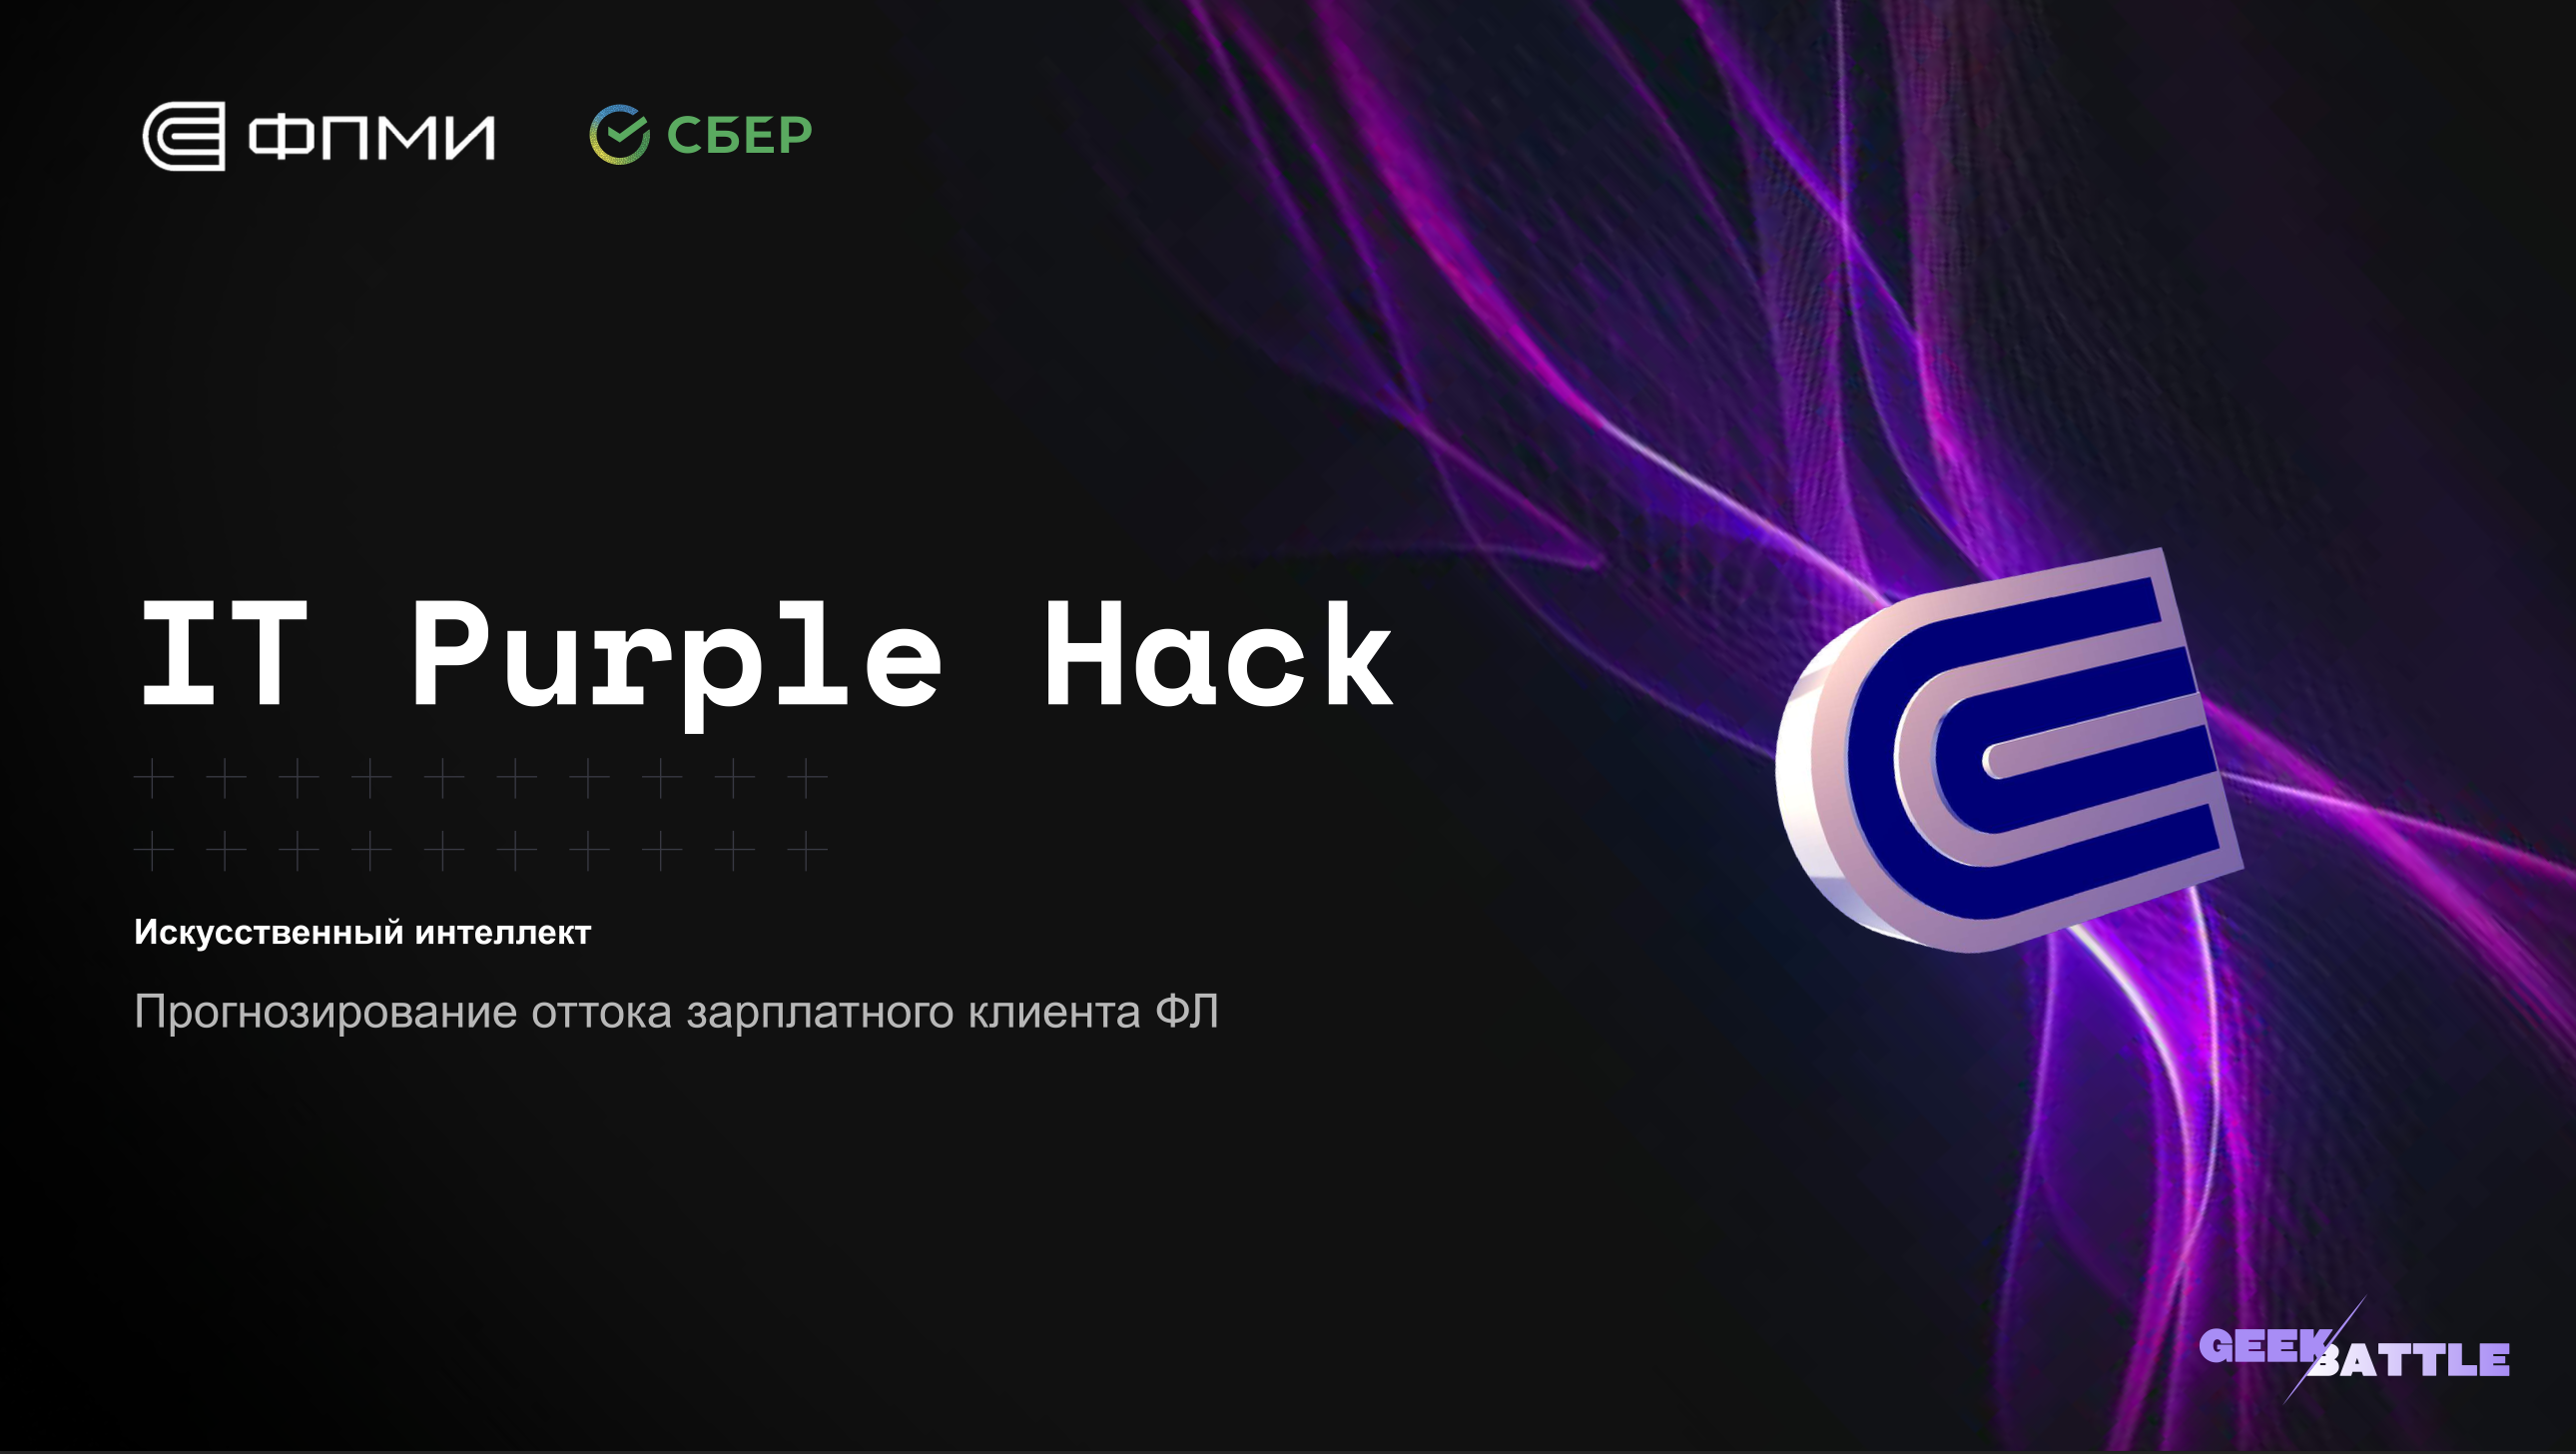

🟣 Проблематика

Банк тратит определенную сумму на привлечение зарплатного клиента (клиента, который официально получает заработную плату на карту банка.). Зарплатный клиент приносит банку больше прибыли, чем обычный клиент. Когда зарплатный клиент уводит свою зарплату из банка в другой банк, то банк теряет прибыль, такие события называются оттоком. Проблема заключается в том, что банк узнает об оттоке по факту отсутствия заработной платы

🟣 Желаемый результат

Модель машинного обучения, которая предсказывает на ежедневной основе отток зарплатных клиентов из банка до возникновения самого события оттока, используя данные поведения клиента: транзакции, продукты, мобильное приложение, терминалы, прочее

# TL;DR

В ходе исследовательского анализа были выявлены следующие особенности данных:
- маскировка типов признаков, наличие разных
- сильный дисбаланс классов
- NaN в двух колонках
- бимодальное распределение строк по количеству нулей
- 88 колонок с одним уникальным значением
- общий низкий уровень уникального количества значений в признаках (абсолютный и относительный)
- - на основе статистического анализа, анализа долей нулевых и униклаьных значений были рассчитаны три группы потенциально категориальных признаков
- 146 бинарных колонок (преимущественно - 0 и 1)
- высокая корреляция и иногда полная идентичность некоторых групп признаков
- повторяющиеся диапазоны признаков, возможно, за разные временные промежутки (либо по разным продуктам)

# Exploratory data analysis

Задача EDA - изучить данные, найти закономерности, характеристики и особенности, на основании которых будет спланирована дальнейшая работа по обработке данных, обучению и тюнингу предиктивной модели

## Подгрузка пакетов и данных

In [1]:
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap
from sklearn.metrics import  roc_auc_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import pickle

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

colors = ["#A115FE", "#8F00FF", "#29AB50", "#22753b", "#A015FE", "#8F00EF", "#ECE919", "#7a781d", "#0F91D0", "#0f3f75"]
sns.set_theme(rc={'figure.figsize':(12,12)})
sns.set_palette(sns.color_palette(colors))

In [2]:
# для локального открытия файла с данными
file_path = "Data/train_ai_comp_final_dp.parquet"
df = pd.read_parquet(file_path, engine='fastparquet').set_index('id', drop=True)

# для скачивания и открытия сырых данных с диска
#df = download_raw_data_from_drive_and_open_in_pandas()

## Первичный взгляд на данные

In [3]:
df.shape

(519615, 1078)

Данные содержат уникальных клиентов, их замаскированные признаки и статус оттока из банка в конце расчетного периода для каждого клиента

In [4]:
df.sample(10, random_state=550)

target  sample_ml_new  feature1  feature2  feature3  feature4  \
id                                                                      
233937       0              1      1671       127        59     70922   
350755       0              1      1641      1405        83    105075   
423929       0              1      1761      1759       115    102239   
260522       0              1      1096      1759       126    105665   
624596       0              1      1548      1759        59     76281   
665014       0              1      1761      1759       113    104517   
245048       0              1      1611       626        32    105571   
169426       0              1      1761      1759        62     93837   
105824       0              1      1761      1759       141    103082   
174231       0              1      1761      1759       121    102308   

        feature5  feature6  feature7  feature8  feature9  feature10  \
id                                                                    
233937        24         1         0         0        24          0   
350755        56         9         0         0        83          0   
423929        21        31         0         0         0          0   
260522       119       137         0         0         0          0   
624596       191        61         0        25        49          0   
665014       191        69         0         0         0          0   
245048        88        93         0         0         0          0   
169426       191        43       125       290       298        176   
105824       191        31         0         0       117          0   
174231        34        25         0        34         0          0   

        feature11  feature12  feature13  feature14  feature15  feature16  \
id                                                                         
233937          0        187         24          1          0          0   
350755          0        187         56          1          0         28   
423929          0        187         21          1          0          0   
260522          0        187        119          1          0          0   
624596          0        187        191          1         25          0   
665014          0         15        191          1          0          0   
245048          0        187         88          1          0          0   
169426        121        187        191        227        282        243   
105824          0        187        191          1          0         87   
174231          0         61         34          1         34          0   

        feature17  feature18  feature19  feature20  feature21  feature22  \
id                                                                         
233937         24          2        183        183        255      89730   
350755         28          6        183        183        255     138806   
423929          0         28          7          7         13     122907   
260522          0         28         18         18         58     138364   
624596          0          4        248        248        347     140184   
665014          0         13        248        248        347     140184   
245048          0         28        206        206        303     119034   
169426        275         28        248        248        347     140184   
105824        117          9        248        248        347     140184   
174231          0          2        183        183        255          0   

        feature23  feature24  feature25  feature26  feature27  feature28  \
id                                                                         
233937          9        248        700          5          8          9   
350755          9        248        500          5          8          9   
423929          9        248       1722          5          8          9   
260522          9        248       1722          5          8          9

🟣 

Сразу можно заметить часто повторяющиеся специфические значения (1761, 1759, 191, 187, 28, 140184, ...) в одних колонках у разных пользователей + распределения колонок разные по виду. Это говорит о том, что в данных спрятаны разные по своей природе признаки

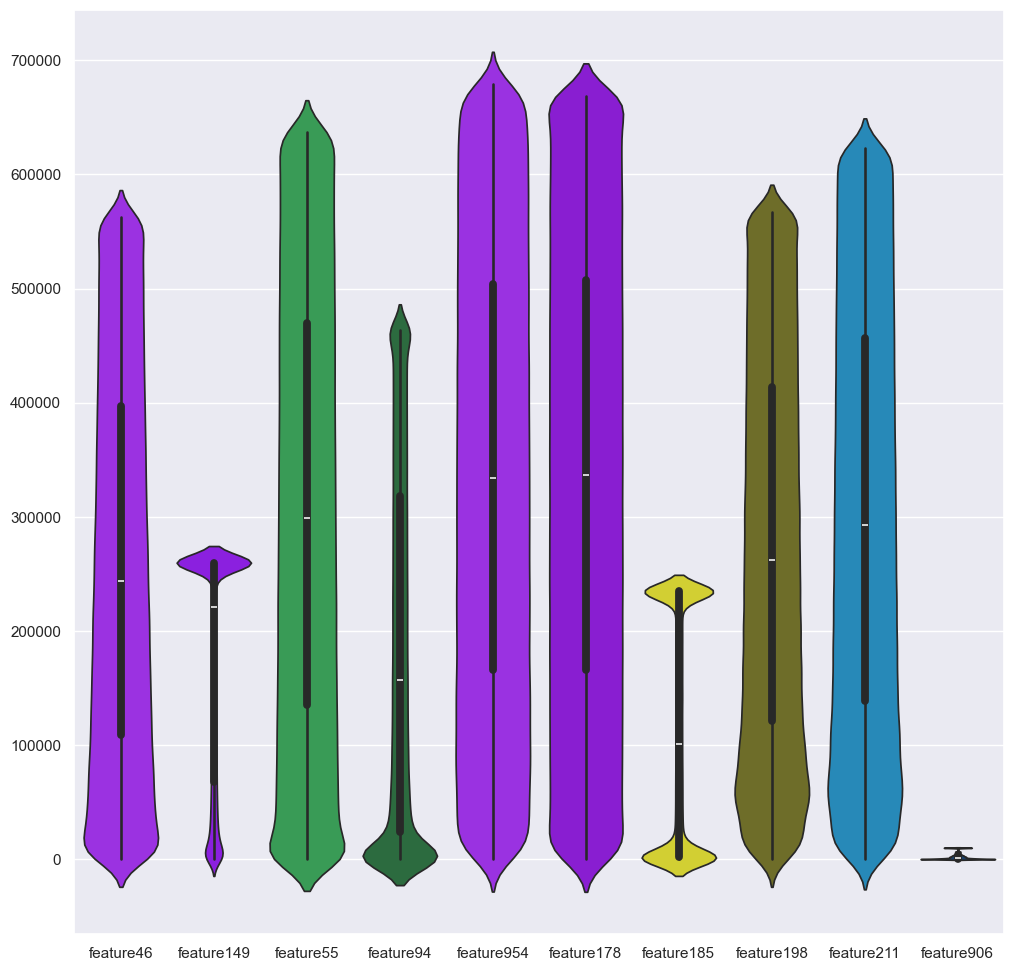

In [5]:
sns.violinplot(df[['feature46','feature149','feature55','feature94','feature954', 
                   'feature178','feature185','feature198','feature211','feature906']], palette=colors)
plt.show()

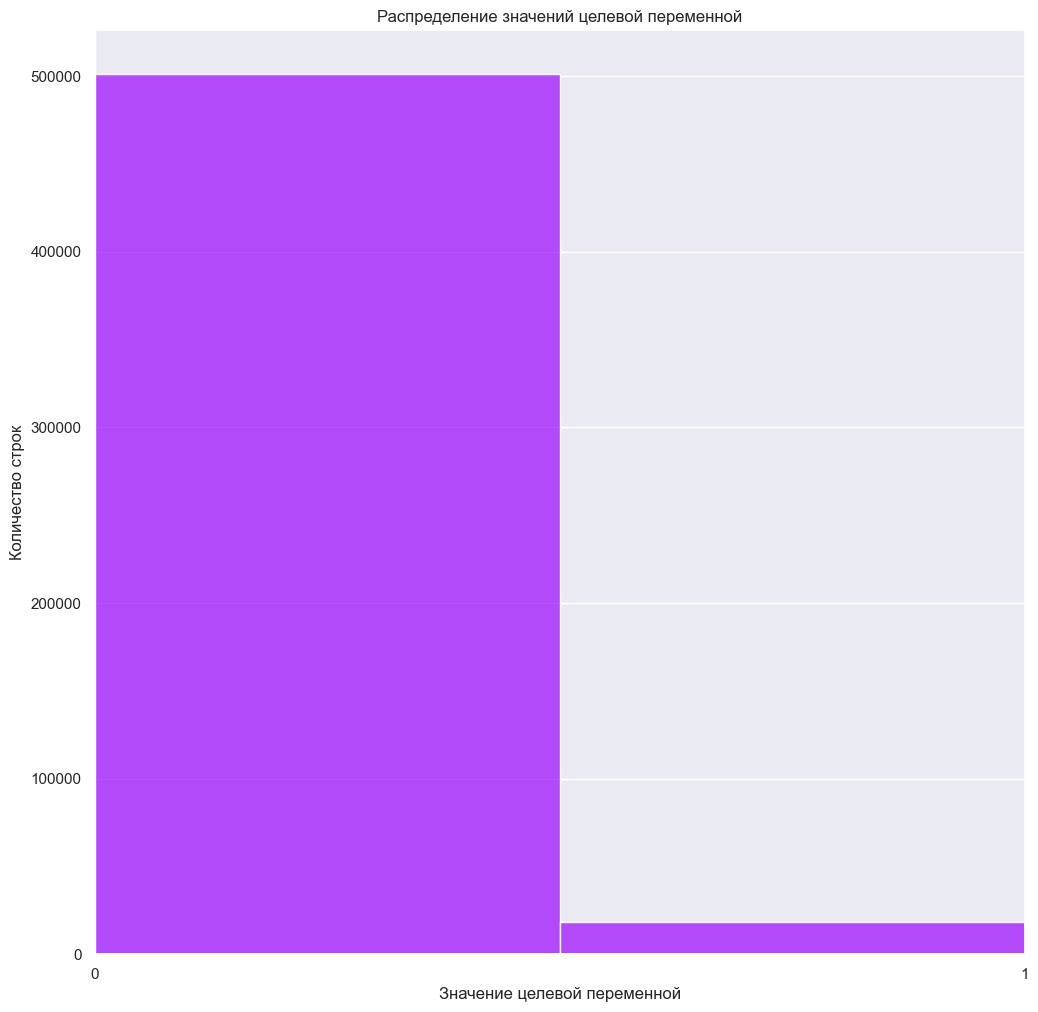

In [6]:
target = df['target']

ax = sns.histplot(target, 
                  bins=2)
ax.xaxis.set_ticks([0, 1])
ax.set_xticklabels([0, 1])
ax.set_title('Распределение значений целевой переменной')
plt.xlabel('Значение целевой переменной')
plt.ylabel('Количество строк')
plt.xlim(0, 1)
plt.show()

🟣 

Мы решаем задачу прогнозирования оттока зарплатного клиента. Факт оттока отмечен значением 0 в целевой переменной, классы соотносятся крайне непропорционально, что потребудет дополнительной обработки до (over-sampling/under-sampling) или во время обучения (алгоритмы на деревьях/работа с loss-функцией)

In [7]:
df.sample_ml_new.unique() # у нас только данные для обучения

array([1])

In [8]:
# проверим типы данных

pd.DataFrame(df.dtypes, columns=['type']).groupby('type').value_counts()

type
int64      1076
float64       2
Name: count, dtype: int64

In [9]:
# проверим колонки с float64

df.columns[df.dtypes != np.int64].to_list()

['feature642', 'feature756']

In [10]:
# проверим признаки на наличие пустых значений

df.columns[df.isna().any()].tolist()

['feature642', 'feature756']

При вероятном наличии категориальных признаков, только два столбца имеют отличающийся от числового тип данных (из-за имеющихся NaN)

In [11]:
df.feature756.unique()

array([nan])

In [12]:
df.feature642.unique()

array([ 0., nan,  1.])

In [13]:
df.feature642.value_counts(dropna=False) / df.shape[0] * 100

feature642
NaN    60.684160
0.0    38.552197
1.0     0.763642
Name: count, dtype: float64

🟣 

В признаке feature756 имеем только пустые значения

В признаке feature642 имеем около 61% пустых значений, 38% нулей и меньше 1% единиц. Для принятия решения по этой колонке проверим корреляцию с целевой переменной

In [14]:
df[['target', 'feature642']].astype('str').fillna('999').corr()

target  feature642
target      1.000000   -0.007747
feature642 -0.007747    1.000000

In [15]:
df[['target', 'feature988']].corr()

target  feature988
target      1.000000   -0.048093
feature988 -0.048093    1.000000

In [16]:
df[['target', 'feature8']].corr()

target  feature8
target    1.000000  0.029312
feature8  0.029312  1.000000

Корреляция с целевой переменной находится на незначительном уровне по сравнению с другими случайными призанаками, что, скорее всего, означает, что мы не сможем качественно использовать оба признака с NaN при обучении

In [17]:
df.drop(['feature756', 'feature642'], axis=1, inplace=True)

Проверим построчные дубли

In [18]:
df.loc[:, 'feature1':'feature1076'].duplicated().sum()

0

🟣 

Посмотрим распределение количества нулей в строках

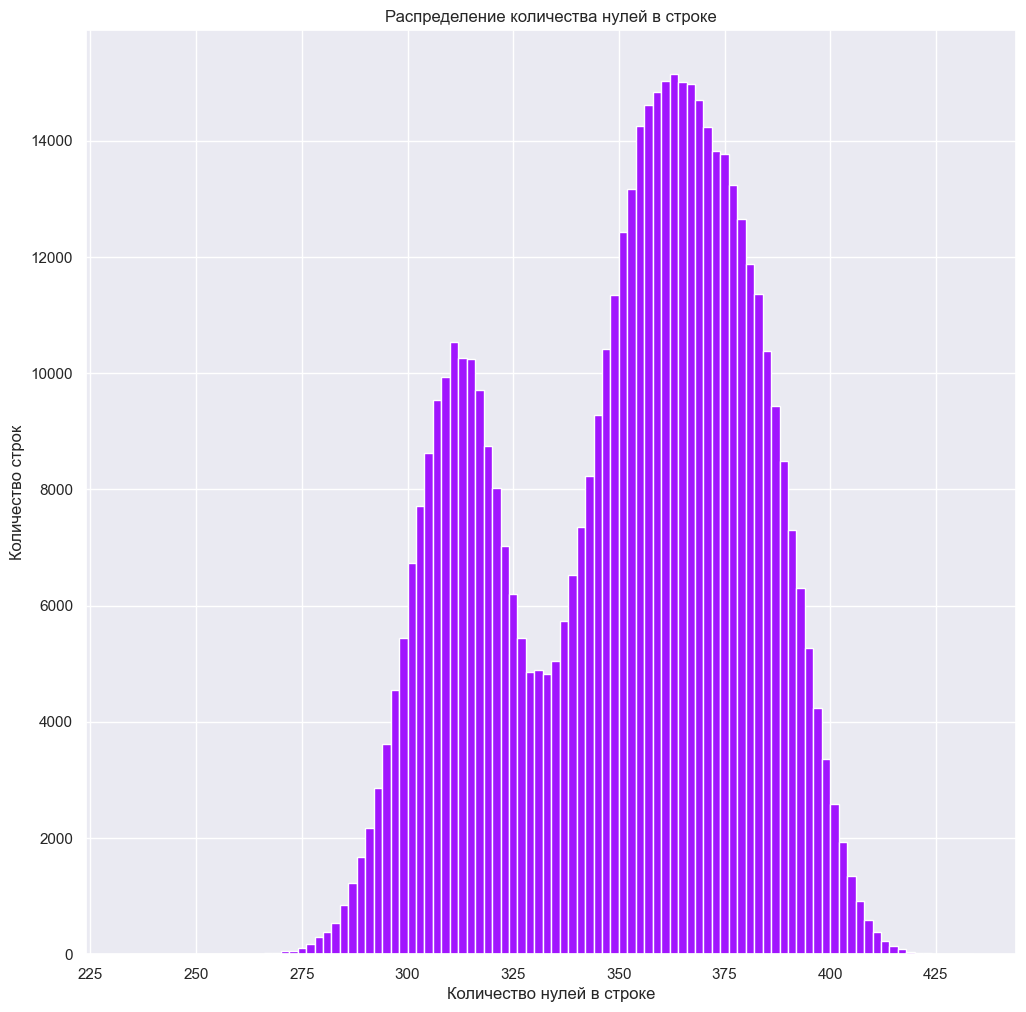

In [19]:
(df == 0).sum(axis=1).hist(bins=100)
plt.title('Распределение количества нулей в строке')
plt.xlabel('Количество нулей в строке')
plt.ylabel('Количество строк')
plt.show()

При разных значениях целевого признака бимодальный характер распределение сохраняется

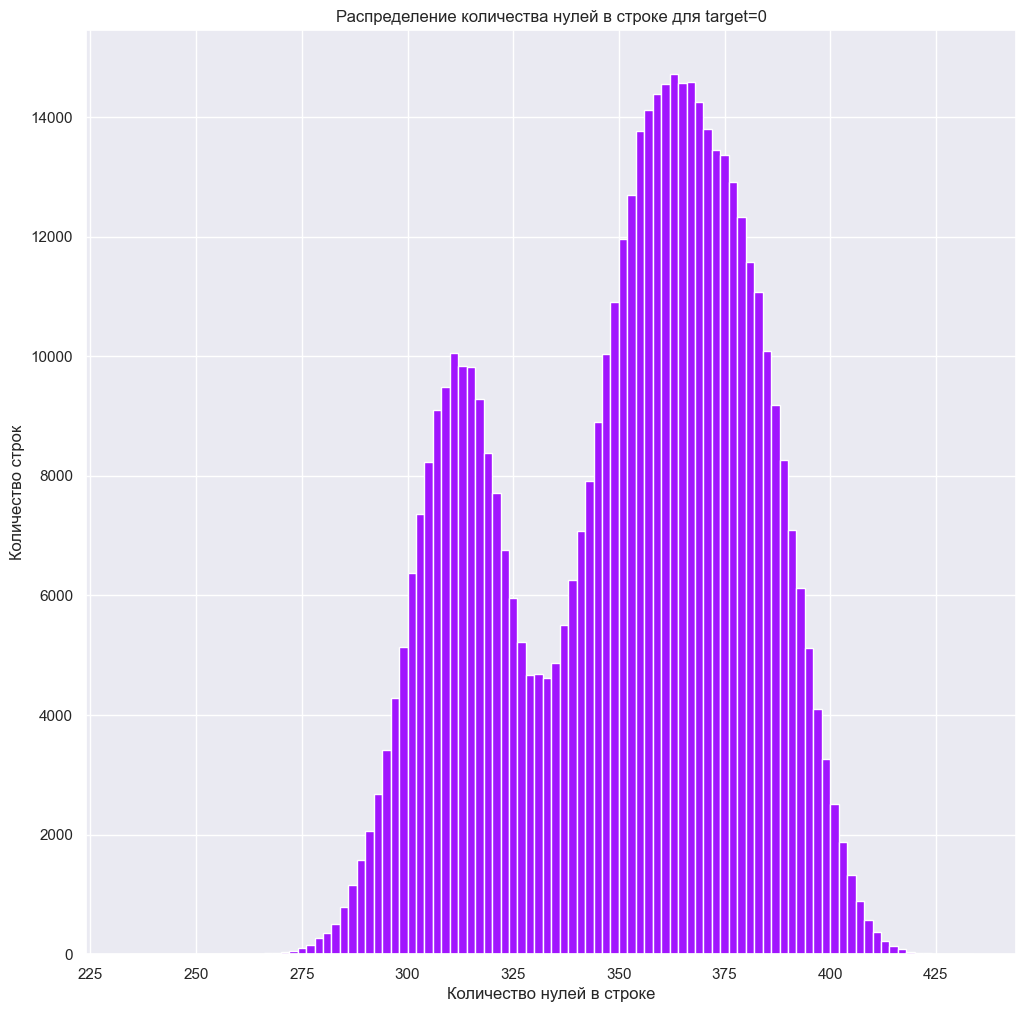

In [20]:
(df[df.target == 0] == 0).sum(axis=1).hist(bins=100)
plt.title('Распределение количества нулей в строке для target=0')
plt.xlabel('Количество нулей в строке')
plt.ylabel('Количество строк')
plt.show()

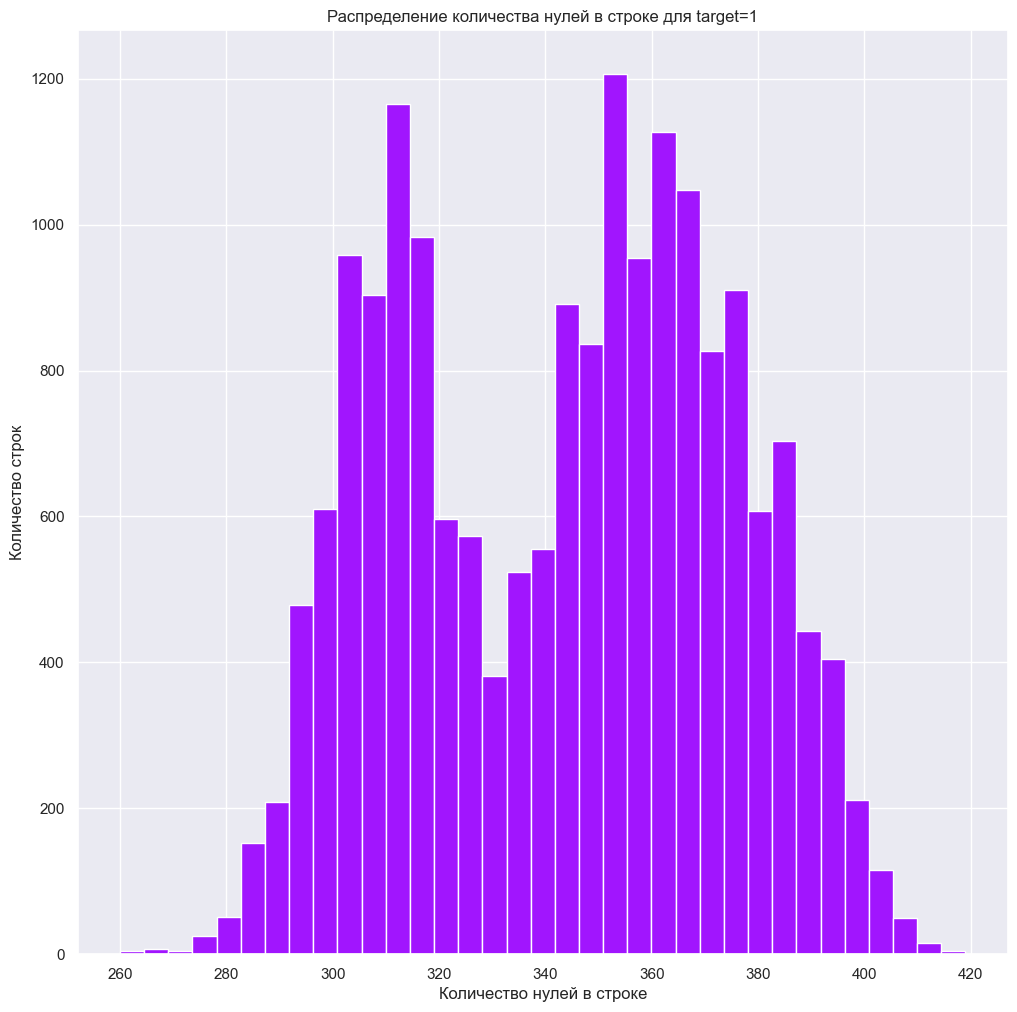

In [21]:
(df[df.target == 1] == 0).sum(axis=1).hist(bins=35)
plt.title('Распределение количества нулей в строке для target=1')
plt.xlabel('Количество нулей в строке')
plt.ylabel('Количество строк')
plt.show()

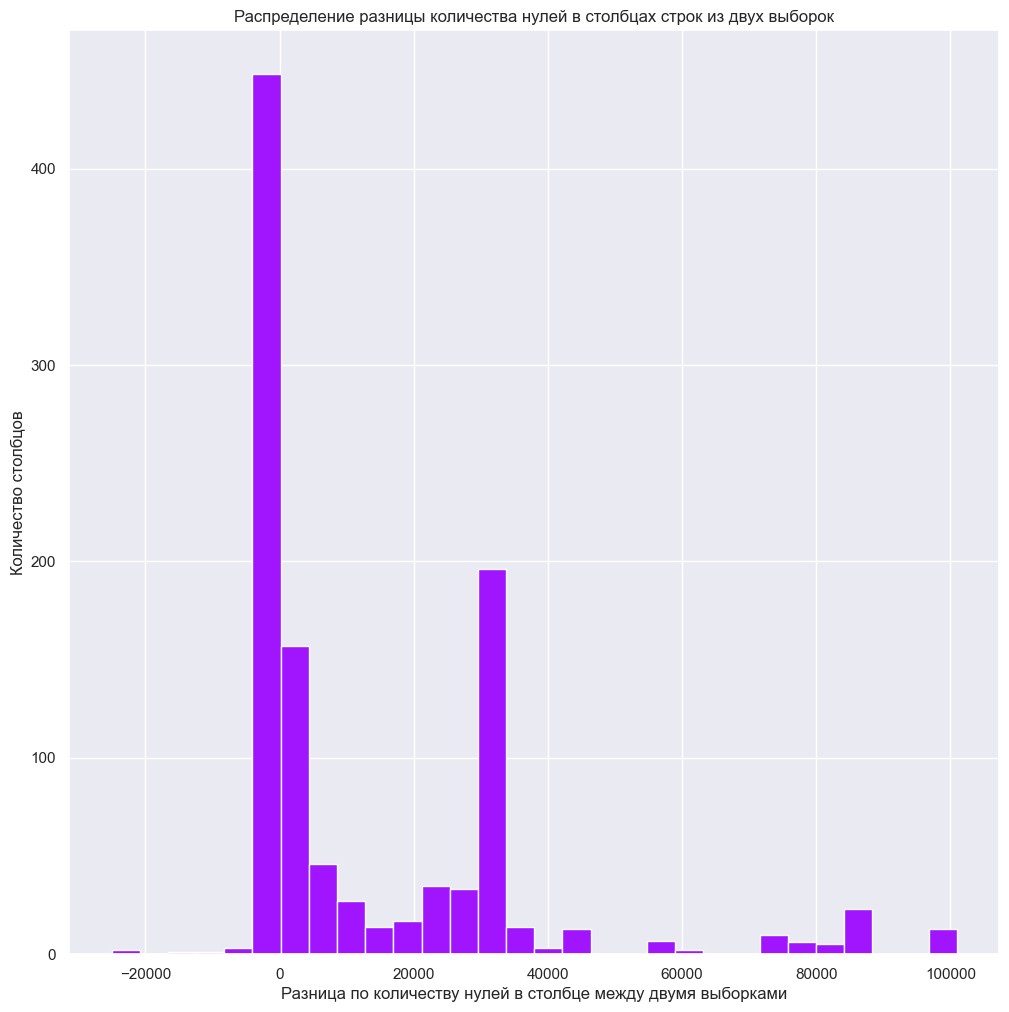

In [22]:
# поколоночная разница количества нулей в двух группах строк, соответствующих двум вершинам распределения

((df[((df == 0).sum(axis=1) < 375) & ((df == 0).sum(axis=1) > 360)] == 0).sum() - 
(df[((df == 0).sum(axis=1) < 320) & ((df == 0).sum(axis=1) > 305)] == 0).sum()).hist(bins=30)
plt.title('Распределение разницы количества нулей в столбцах строк из двух выборок')
plt.xlabel('Разница по количеству нулей в столбце между двумя выборками')
plt.ylabel('Количество столбцов')
plt.show()

🟣 

Распределение очень интересное: больше половины колонок (~570) у двух выборок строк, соответствуюшим двум пикам распределения с графиков выше, с минимальными различиями совпадают по количеству нулей, при этом около 200 колонок создают различия одного порядка - примерно 38000 

🟣 

При всем при этом не хватает уверенности утверждать, что это важная особенность - распределения для target=0 и для target=1 в этом разрезе совпадают

In [23]:
df.drop(['target', 'sample_ml_new'], axis=1, inplace=True)

🟣 

При вервичном взгляде на данные были обнаружены замаскированные признаки разных категорий, дисбаланс классов, две колонки с NaN, любопытное распределение количества нулей в строках

Продолжим исследования далее

## Исследование типов признаков

🟣 

Из-за отсутствия описания признаков для нас неочевидно, какие из них являются категориальными, какие - датами или временными отсечками, а какие - числовыми/количественными. При этом нам важно попробовать выделить категориальные для применения более подходящей обработки при обучением в целях повышения точности модели

Для начала посмотрим на кол-во уникальных значений в каждом признаке

In [24]:
df.nunique()

feature1         1728
feature2         1728
feature3          141
feature4        80146
feature5          189
feature6          281
feature7          120
feature8          287
feature9          297
feature10         168
feature11         117
feature12         184
feature13         189
feature14         225
feature15         279
feature16         243
feature17         273
feature18          29
feature19         219
feature20         219
feature21         291
feature22      108457
feature23           8
feature24         239
feature25        1649
feature26           4
feature27           7
feature28           8
feature29         241
feature30        1666
feature31         489
feature32        1358
feature33       39329
feature34       41131
feature35       52160
feature36        2784
feature37       65129
feature38       10855
feature39        8780
feature40       12372
feature41        5816
feature42        2405
feature43       47945
feature44        5368
feature45        9845
feature46 

🟣 

Можем заметить следующие особенности: 
- есть признаки с одним уникальным значением
- общее низкое количество уникальных значений в колонках относительно размера датасета
- большре количество бинарных признаков
- признаки с повторяющимся количеством уникальных значений последовательно и часто попарно

Разберем каждый пункт детальнее

🟣 

Найдем и дропнем все признаки с только одним уникальным значением, они не дадут модели дополнительной информации о закономерностях в данных

In [25]:
print(len(df.columns[df.nunique() == 1].to_list()))

df.drop(df.columns[df.nunique() == 1].to_list(), axis=1, inplace=True)

88


🟣 

Рассмотрим распределение количества уникальных значений в фичах (без учета бинарных)

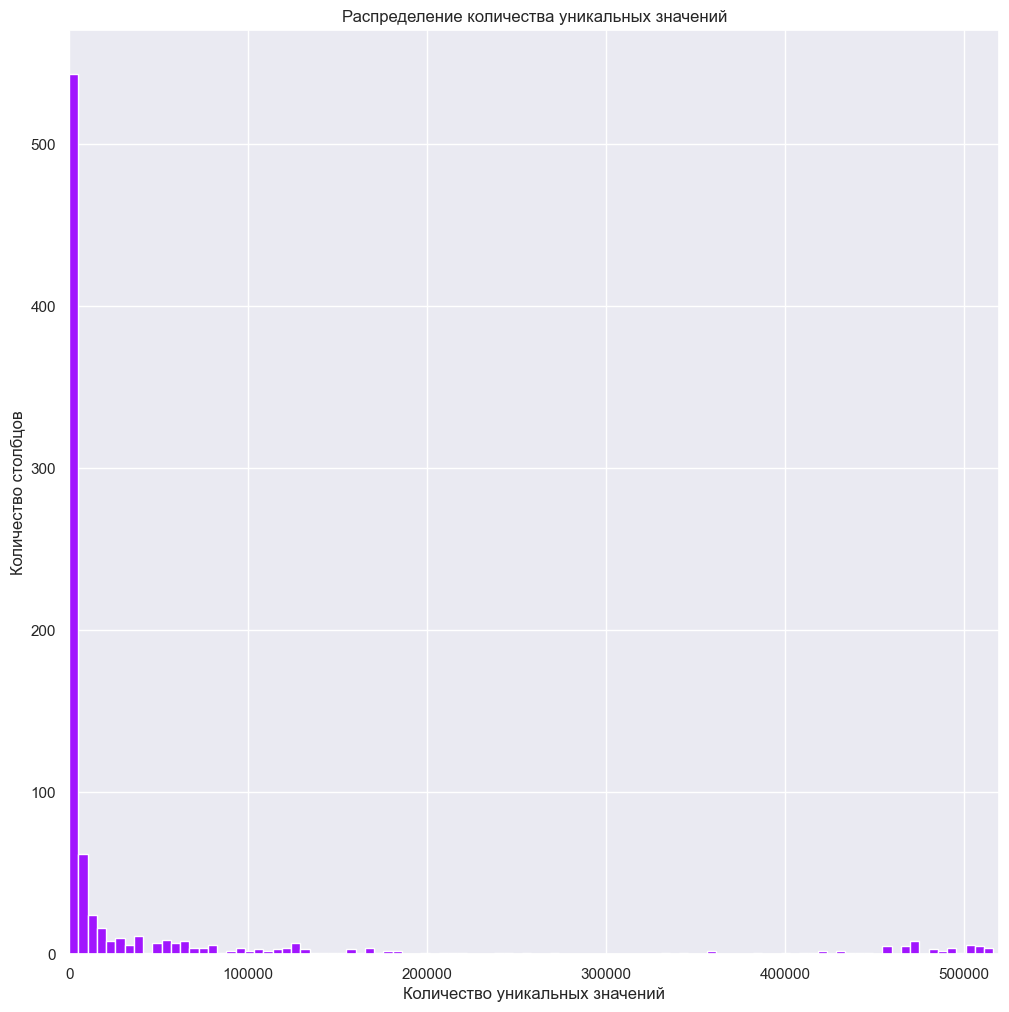

In [26]:
plt.hist(df[df.columns[~(df.nunique() == 2)]].nunique(), 
         bins = 100)
plt.title('Распределение количества уникальных значений')
plt.xlabel('Количество уникальных значений')
plt.ylabel('Количество столбцов')
plt.xlim(0, df.shape[0])
plt.show()

🟣 

По графику видно следующее:
- подавляющая часть признаков имеет минимальное количество уникальных значений
- небольшая группа признаков имеет практически полностью уникальные значения (правый край графика)
- еще одна небольшая группа имеет промежуточные количественные показатели уникальности значений ближе к 100000

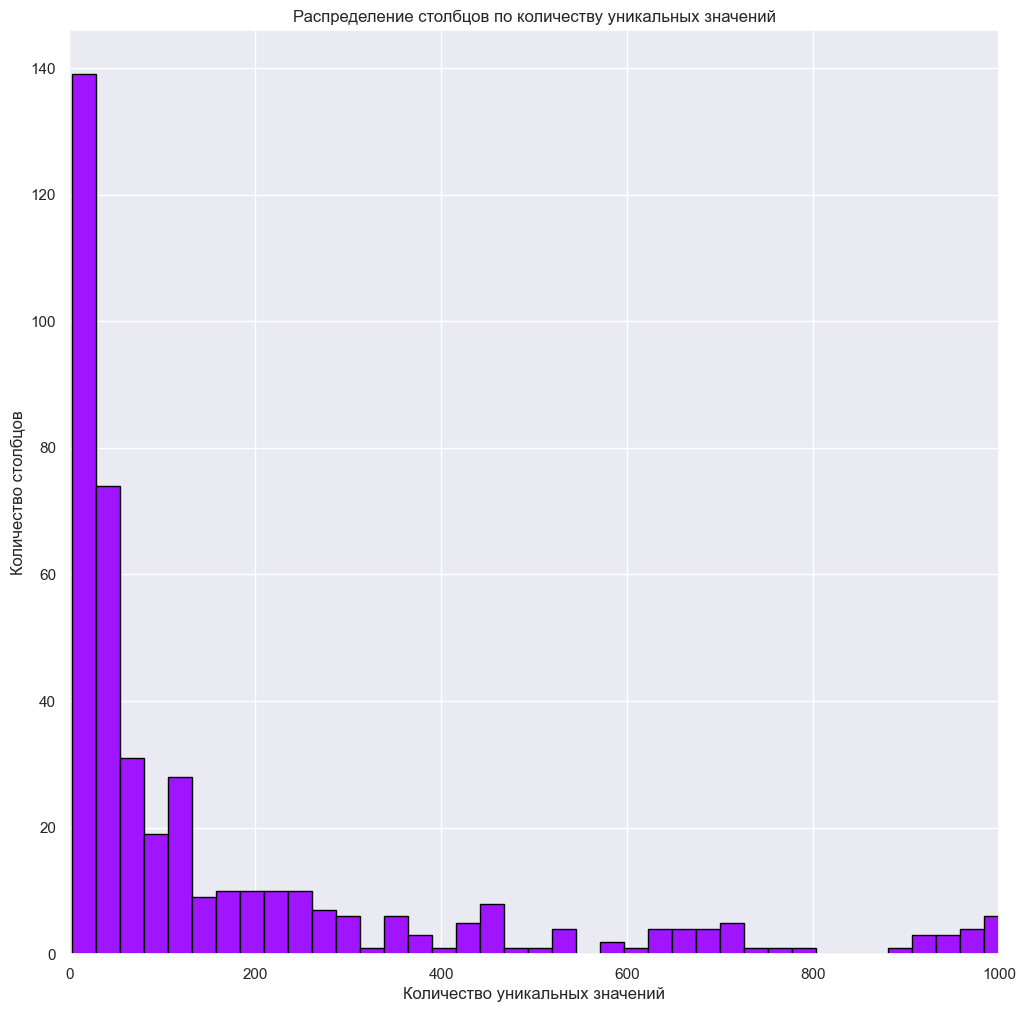

In [27]:
# тот же график с приближением на начало осей

plt.hist(df[df.columns[~(df.nunique() == 2)]].nunique(), 
         bins = 20000,
         edgecolor='black')
plt.title('Распределение столбцов по количеству уникальных значений')
plt.xlabel('Количество уникальных значений')
plt.ylabel('Количество столбцов')
plt.xlim(0, 1000)
plt.show()

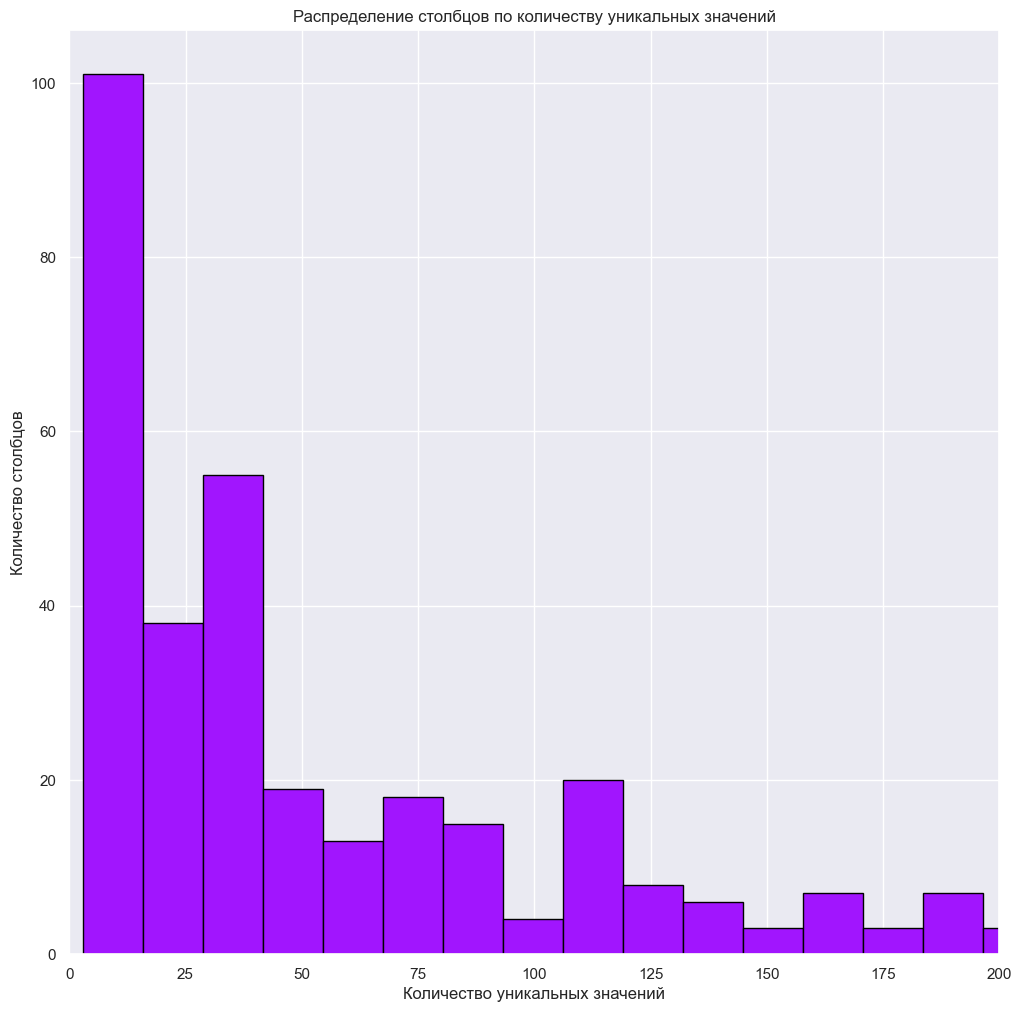

In [28]:
# тот же график с приближением на начало осей

plt.hist(df[df.columns[~(df.nunique() == 2)]].nunique(), 
         bins = 40000,
         edgecolor='black')
plt.title('Распределение столбцов по количеству уникальных значений')
plt.xlabel('Количество уникальных значений')
plt.ylabel('Количество столбцов')
plt.xlim(0, 200)
plt.show()

🟣 

По более детальным графикам видно, что около 350 признаков (без учета бинарных) имеют вариативность до 100 уникальных значений на признак, еще около 100 - до 1000, что потенциально может говорить об их категориальной природе, но так же и о количественно (например, количестве каких-то действий за период)

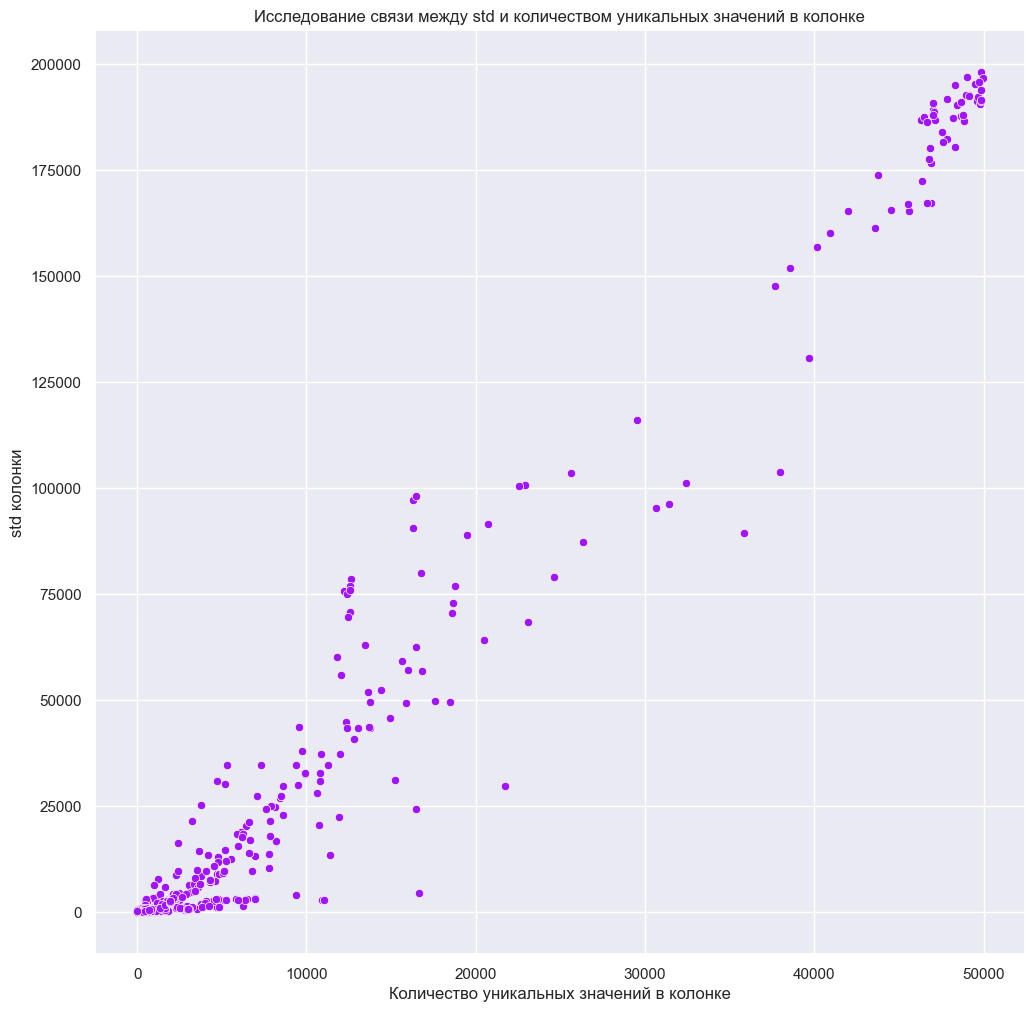

In [29]:
sns.scatterplot(data=df.sample(n=50000), x=df.sample(n=50000).nunique(), y=df.sample(n=50000).std())
plt.xlabel('Количество уникальных значений в колонке')
plt.ylabel('std колонки')
plt.title('Исследование связи между std и количеством уникальных значений в колонке')
#plt.ylim(0, 500)
#plt.xlim(0, 200)
plt.show()

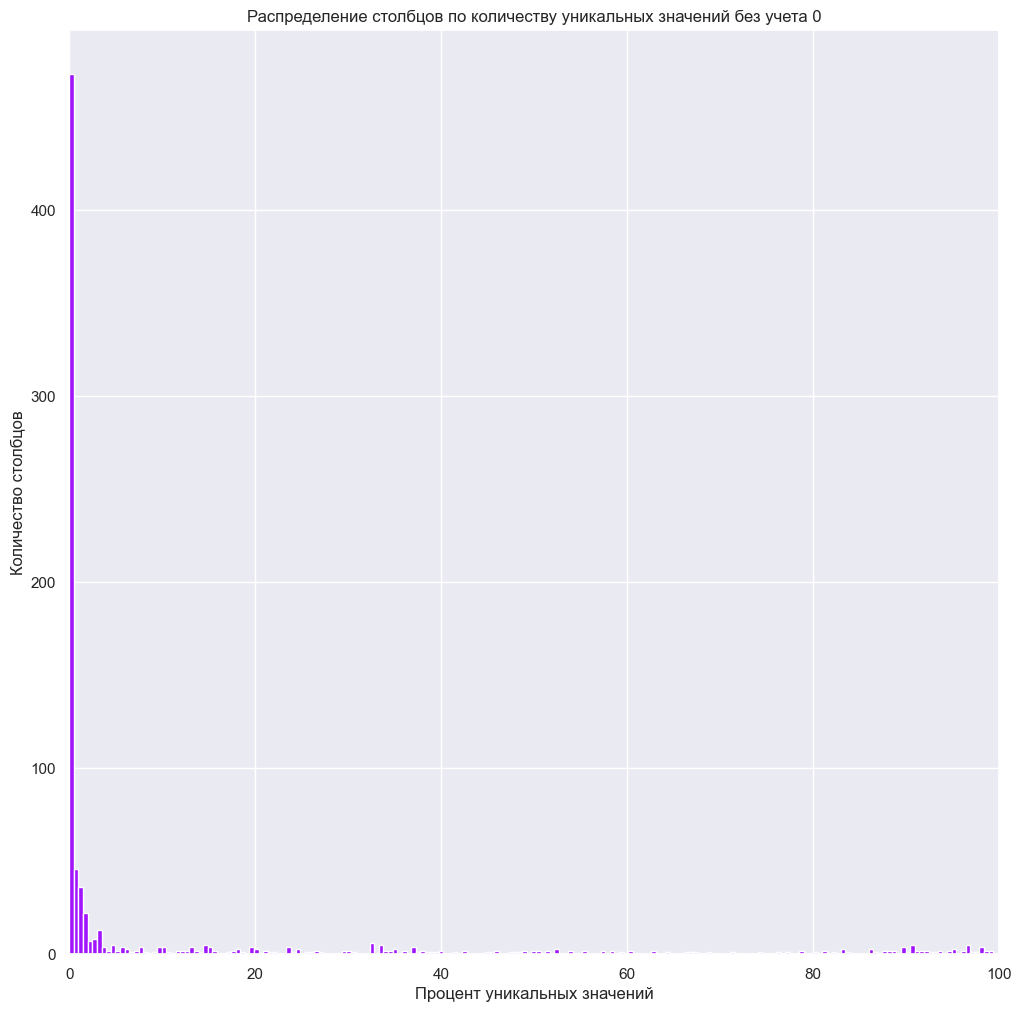

In [30]:
plt.hist(df[df.columns[~(df.nunique() == 2)]].nunique() / (df != 0).sum() * 100, 
         bins = 200)
plt.title('Распределение столбцов по количеству уникальных значений без учета 0')
plt.xlabel('Процент уникальных значений')
plt.ylabel('Количество столбцов')
plt.xlim(0, 100)
plt.show()

🟣 

По графику видно, что подавляющее число столбцов имеет низкий % уникальных значений относительно размера колонки даже без учета строк, равных 0 (предположительная замена пропуску)

Это могут быть как количественные признаки по типу агрегированных логов работы с продуктами банка, так и категориальные

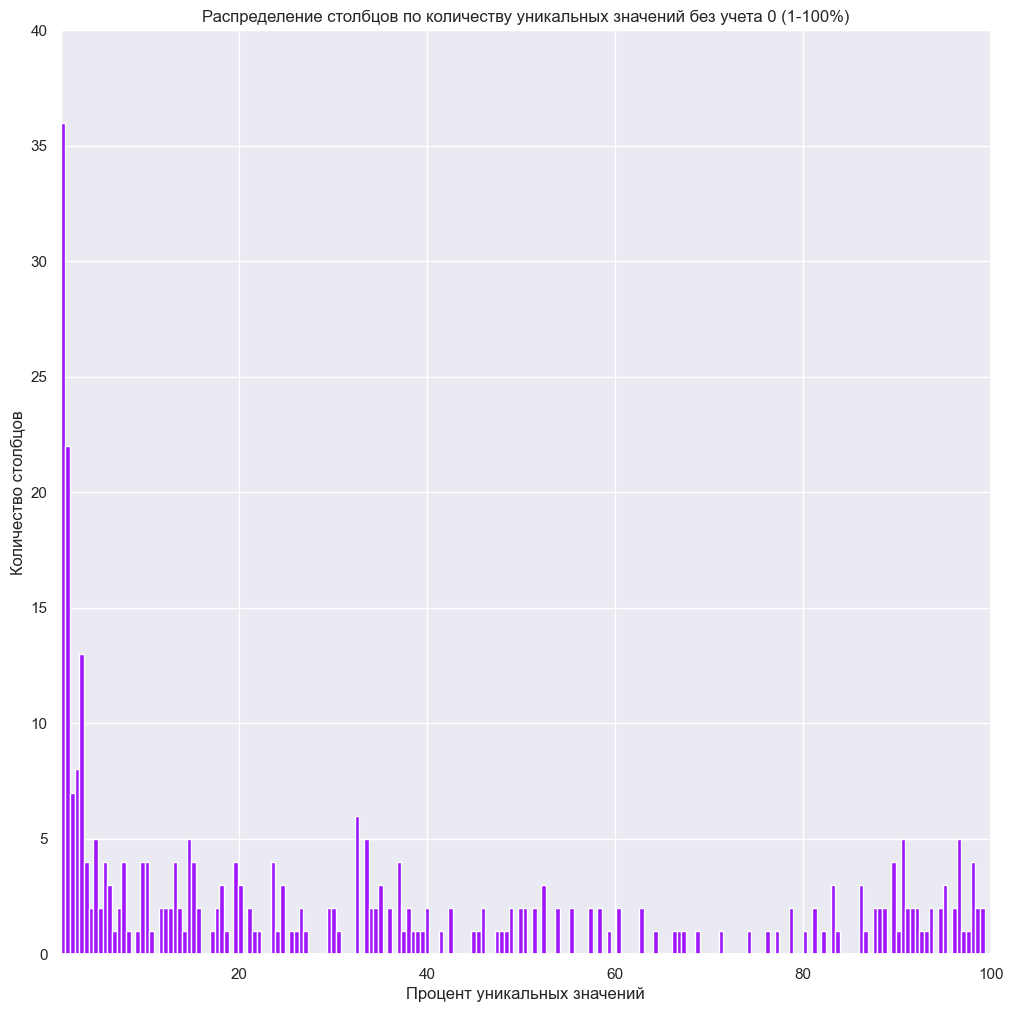

In [31]:
plt.hist(df[df.columns[~(df.nunique() == 2)]].nunique() / (df != 0).sum() * 100, 
         bins = 200)
plt.title('Распределение столбцов по количеству уникальных значений без учета 0 (1-100%)')
plt.xlabel('Процент уникальных значений')
plt.ylabel('Количество столбцов')
plt.xlim(1, 100)
plt.ylim(0, 40)
plt.show()

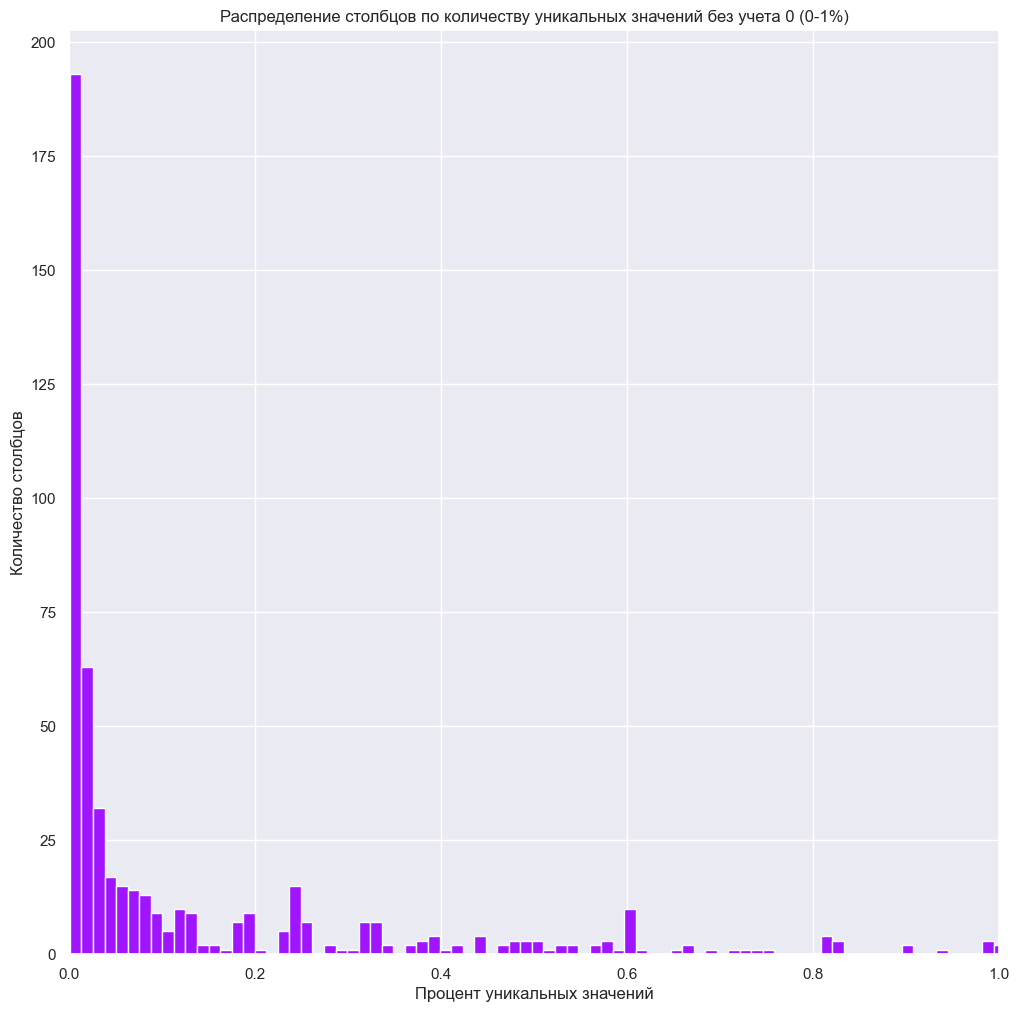

In [32]:
plt.hist(df[df.columns[~(df.nunique() == 2)]].nunique() / (df != 0).sum() * 100, 
         bins = 8000)
plt.title('Распределение столбцов по количеству уникальных значений без учета 0 (0-1%)')
plt.xlabel('Процент уникальных значений')
plt.ylabel('Количество столбцов')
plt.xlim(0, 1)
plt.show()

🟣 

После приближения графиков видно, что значительное количество колонок имеет всего ~0.6% уникальных значений относительно размера столбца без учета строк, равных 0 (а пик и резкий спад находятся диапазоне от 0% до 0.15%)

In [33]:
# максимальное количество уникальных значений в выбранных нами признаках

df.shape[0] * 0.15 / 100

779.4225

In [34]:
(df[df.columns[~(df.nunique() == 2)]].nunique() / (df != 0).sum() * 100 <= 0.15).sum()

382

🟣 

Можем предположить, что ~382 небинарные колонки могут являться категориальными. Но в то же время, они могут быть и численными, например, количество некоторых действий за период. Попробуем разделить эти признаки. У численных, если их не отскалировали, должен быть перекос в сторону нуля и равномерное распределение

In [35]:
# найдем бинарные колонки
binar = list(df.columns[df.nunique() == 2])

cat_indexes = df[df.columns[~(df.nunique() == 2)]].nunique().div((df[df.columns[~(df.nunique() == 2)]] != 0).sum().values, axis=0) * 100 <= 0.15
potentially_categorical = set(cat_indexes[cat_indexes == True].index)

#potentially_categorical = binar.union(set(cat_indexes[cat_indexes == True].index))

# из потенциально категориальных попробуем вычесть колонки, которые могут быть численными
potentially_continuous = set(df.columns[df.isin([0]).any() & \
                                        df.isin([1]).any() & \
                                        df.isin([2]).any() & \
                                        df.isin([3]).any() & \
                                        df.isin([4]).any() & \
                                       (df.nunique() <= 500)])

cat_cols = potentially_categorical - potentially_continuous

In [36]:
len(cat_cols)

75

In [37]:
df[list(cat_cols)].sample(10)

feature10  feature564  feature60  feature31  feature488  feature582  \
id                                                                            
304567          0           4         63        633          53           0   
409560          0           4         63        633          11           0   
215632          0           4         63        633          50           0   
92101         176           4         63        633          77           2   
87533           0           4         63        633         114           0   
148961          0           4         63        633          63           0   
120384          0           4         63        633          14           0   
223097          0           4         63        459          87           0   
566024        176           4         63        633         166           2   
177207        176           4         63        633          54           2   

        feature757  feature285  feature584  feature748  feature326  \
id                                                                   
304567           2          32           0           6        1222   
409560           0          32           0           6        1222   
215632           0          32           0           6        1222   
92101            0          32           8           6        1222   
87533            0          32           0           6        1222   
148961           0          32           0           6        1222   
120384           0          32           0           6        1222   
223097           0          32           0           6        1222   
566024           0          32           8           6        1222   
177207           0          32           8           6        1222   

        feature325  feature70  feature301  feature910  feature471  feature146  \
id                                                                              
304567          10        247          11           9           2         852   
409560          10        247          11           9           2         852   
215632          10        247          11           9           2         852   
92101           10        247          11           9           2         852   
87533           10        247          11           9           2         852   
148961          10        247          11           9           2         852   
120384          10        247          11           9           2         852   
223097          10        247          11           9           2         852   
566024          10        247          11           9           2         852   
177207          10        247          11           9           2         852   

        feature585  feature298  feature273  feature904  feature62  feature553  \
id                                                                              
304567           0         823          38        1270        109           5   
409560           0         823          38        1270         67           5   
215632           0         823          38        1270        736          12   
92101           15         823          38        1270        736           8   
87533            0         823          38        1270        109          15   
148961           0         823          38        1270        736           4   
120384           0         823          38        1270        736          16   
223097           0         823          38        1270         56          23   
566024          15         823          38        1270        736          41   
177207          15         823          38        1270        736          28   

        feature903  feature886  feature506  feature392  feature281  \
id                                                                   
304567           4           5          63           1           8   
409560           4           5         132           1        

🟣 

При просмотре среда данных можно заметить несколько колонок, все-таки похожих на непрерывные / количественные признаки:
- feature488
- feature506
- feature475
- feature474
- feature559
- feature560
- feature553

Рассмотрим их поближе

<Axes: >

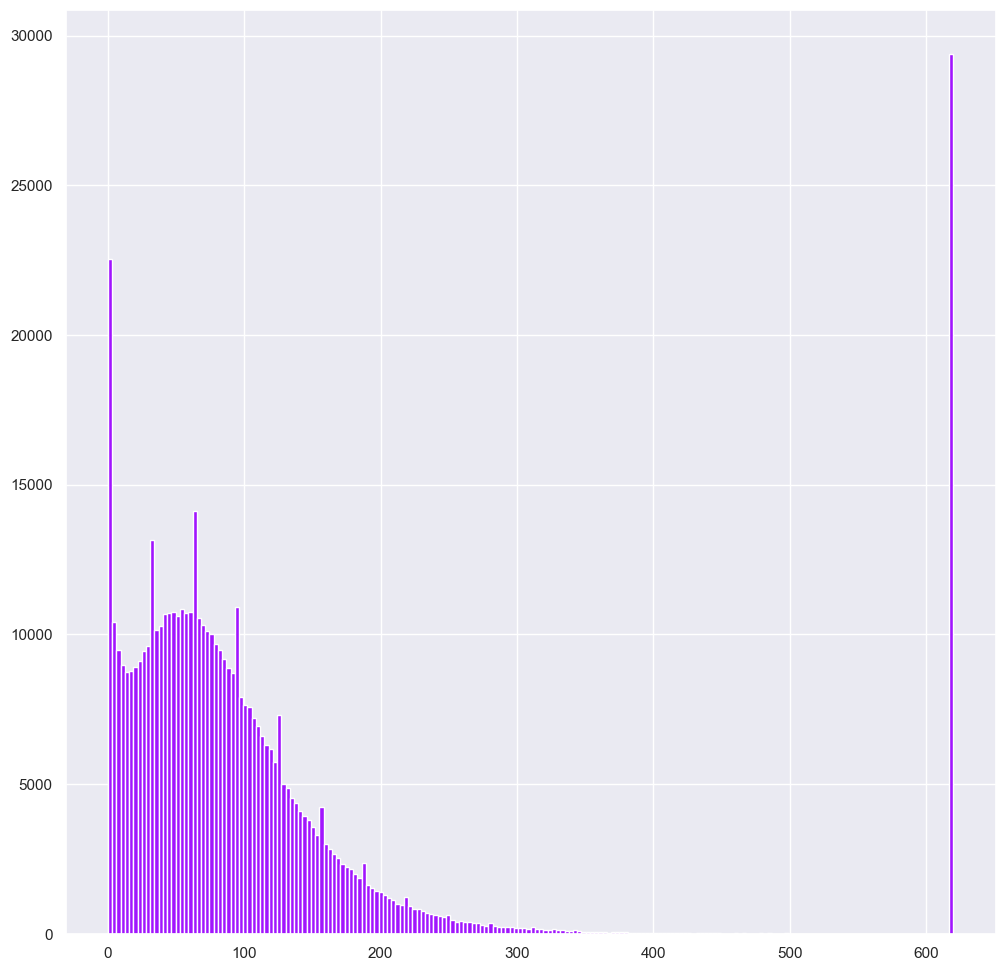

In [38]:
df.feature506.hist(bins=200)

<Axes: >

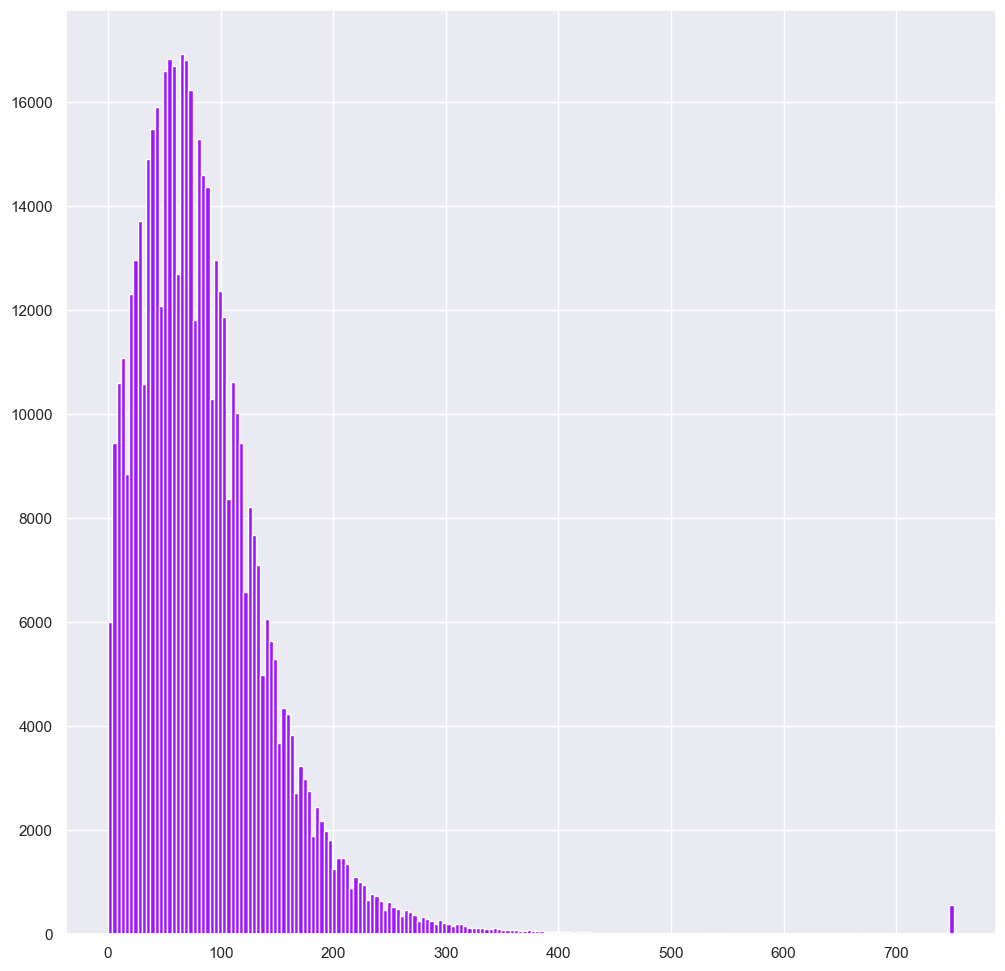

In [39]:
df.feature560.hist(bins=200)

Специфика этих колонок заключается в нормальном распределение в районе нуля и "выбросом" разного объема по одному большому значению

In [40]:
df[['feature488', 'feature506', 'feature475', 'feature474', 'feature559', 'feature560', 'feature553']].describe()

feature488     feature506     feature475     feature474  \
count  519615.000000  519615.000000  519615.000000  519615.000000   
mean       83.618423     111.782275      53.147956      21.649144   
std        66.830063     138.322773     146.607341      43.676726   
min         0.000000       0.000000       0.000000       0.000000   
25%        41.000000      38.000000       4.000000       7.000000   
50%        72.000000      75.000000       9.000000      13.000000   
75%       110.000000     124.000000      21.000000      24.000000   
max       702.000000     620.000000     590.000000     684.000000   

          feature559     feature560     feature553  
count  519615.000000  519615.000000  519615.000000  
mean       84.597100      84.561554      39.582404  
std        62.370114      62.368364     119.848298  
min         0.000000       0.000000       0.000000  
25%        43.000000      43.000000       5.000000  
50%        74.000000      74.000000      12.000000  
75%       113.000000     113.000000      24.000000  
max       753.000000     751.000000     676.000000

In [41]:
df[['feature488', 
    'feature506', 
    'feature475', 
    'feature474', 
    'feature559', 
    'feature560', 
    'feature553']].max() / \
df[['feature488', 
    'feature506', 
    'feature475', 
    'feature474', 
    'feature559', 
    'feature560', 
    'feature553']].quantile(q=0.9)

feature488     4.588235
feature506     3.084577
feature475    11.346154
feature474    16.682927
feature559     4.796178
feature560     4.783439
feature553    14.083333
dtype: float64

🟣 

Эту особенность можно выделить через квантиль 90% и максимвльное значение в столбце, максимальное значение для найденных колонок должно более трех раз превышать выбранный квантиль

In [42]:
df[df.columns[(df.max() / df.quantile(q=0.9) < np.inf) & (df.max() / df.quantile(q=0.9) > 3)]].sample(10)

feature6  feature52  feature53  feature322  feature323  feature343  \
id                                                                           
141937        23          0          0          37          37           4   
603395         1          0          0          47          47           0   
609448        15          0          0         493         493           0   
657473        14          0          0         458         458           0   
264750        59          0          0         785         785           0   
602040        19         39         50         476         476           0   
177575        34          0          0        1058        1058           0   
523168       134          0          0         332         332           0   
562329        42          0          0        1267        1267           0   
23967         42          0          0          74          74           0   

        feature344  feature345  feature356  feature369  feature370  \
id                                                                   
141937          17           4          15           2           4   
603395           0           0           0           0           2   
609448           3           0           5           1          15   
657473           0           0          24           1          32   
264750           0           0           4           1          28   
602040           0           0          10           1          14   
177575           0           0           2           2          24   
523168           0           0           2           1          11   
562329           0           0           0           2          11   
23967            1           0           1           1          32   

        feature371  feature374  feature375  feature376  feature377  \
id                                                                   
141937          15           4          16           0           0   
603395           5           2           6           0           0   
609448          49          15          50           0           0   
657473          88          32          89           0           0   
264750         103          28         104           0           0   
602040          48          11          45           3           4   
177575          55          24          56           0           0   
523168          33          11          34           0           0   
562329          53          11          54           0           0   
23967           68          32          69           0           0   

        feature378  feature379  feature398  feature402  feature427  \
id                                                                   
141937           4          16           1           1           3   
603395           2           6           0           0           1   
609448          15          50           0           0           1   
657473          31          87           1           1           1   
264750          28         104           0           0           1   
602040          11          45           0           0           1   
177575          24          56           0           0           2   
523168          11          34           0           0           1   
562329          11          54           0           0           2   
23967           32          69           1           1           2   

        feature428  feature429  feature436  feature448  feature469  \
id                                                                   
141937           3           3           3           3           7   
603395           0           5           5         450           1   
609448           1           1           2          44          20   
657473           1           3           3          76           3   
264750           1           1           1          48          12   
602040           1           3           3         450    

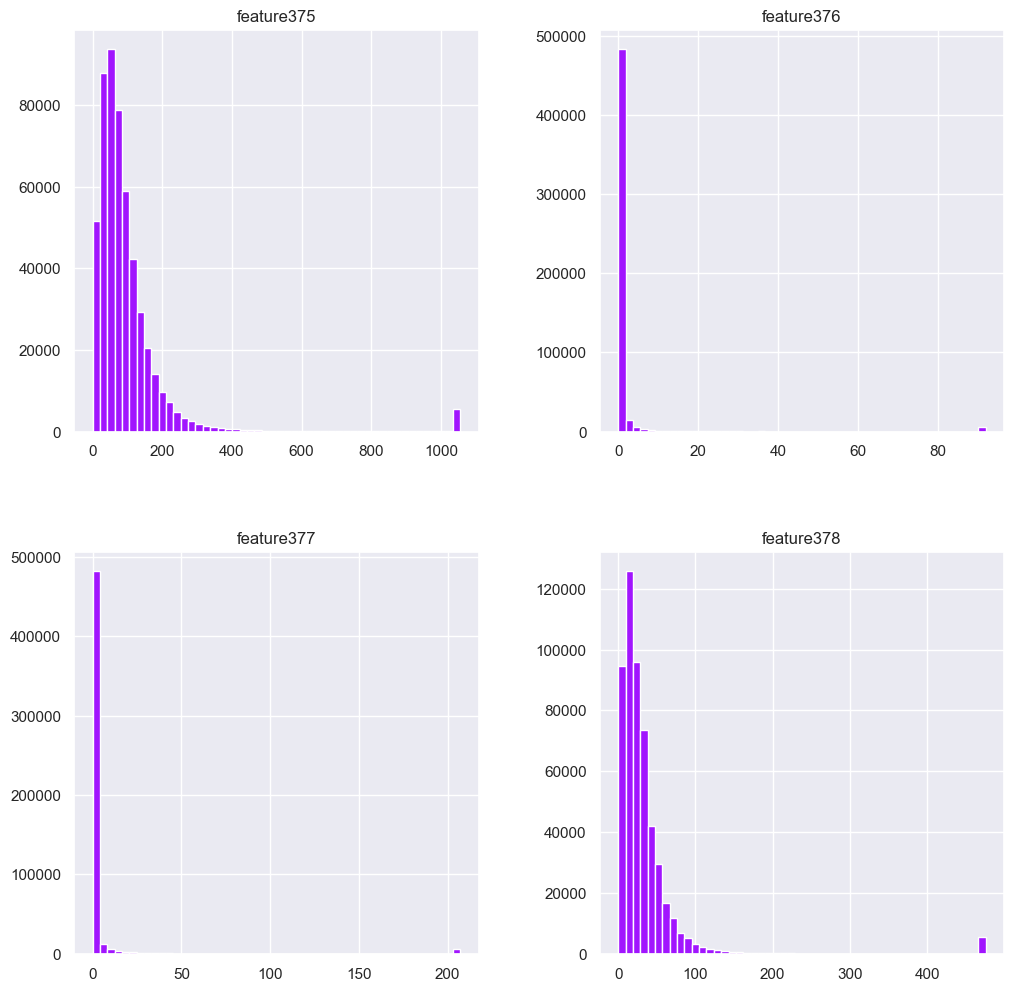

In [43]:
df[df.columns[(df.max() / df.quantile(q=0.9) < np.inf) & (df.max() / df.quantile(q=0.9) > 4.5)]].iloc[:, 10:14].hist(bins=50)
plt.show()

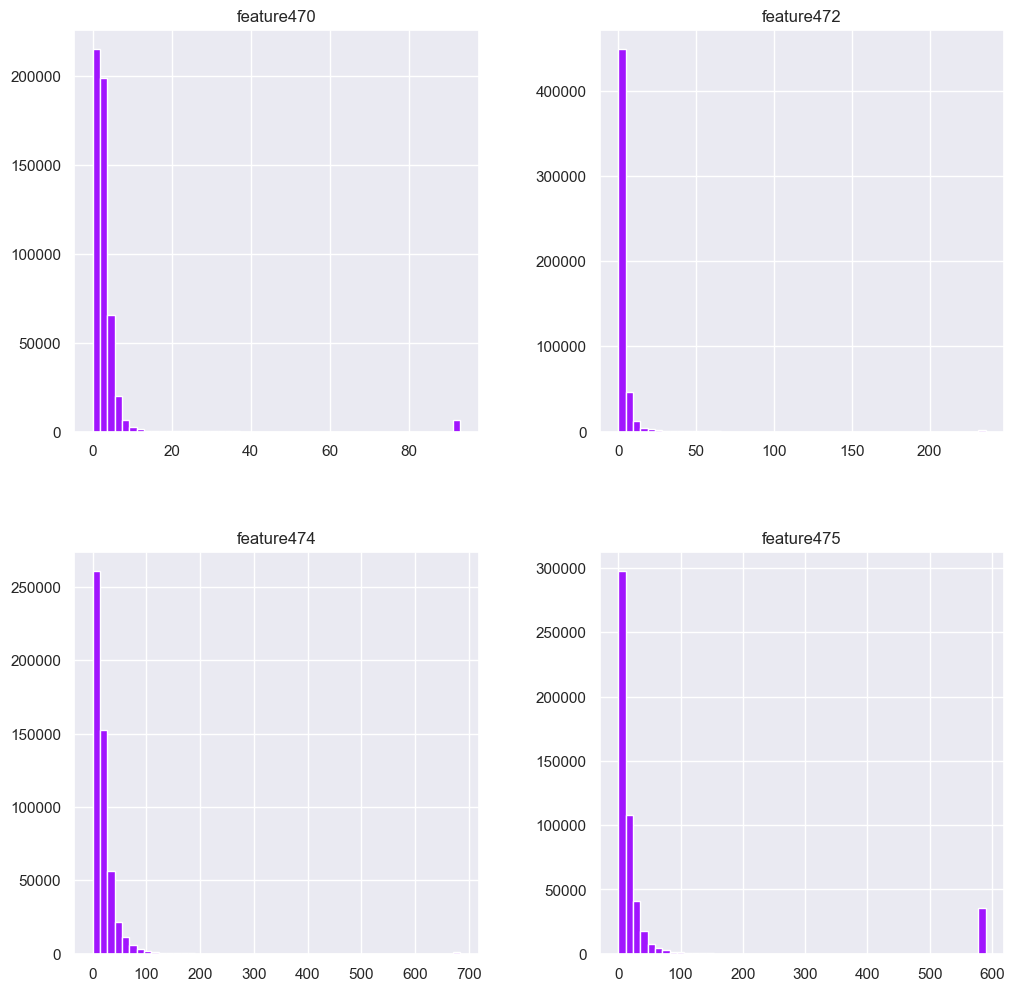

In [44]:
df[df.columns[(df.max() / df.quantile(q=0.9) < np.inf) & (df.max() / df.quantile(q=0.9) > 4.5)]].iloc[:, 20:24].hist(bins=50)
plt.show()

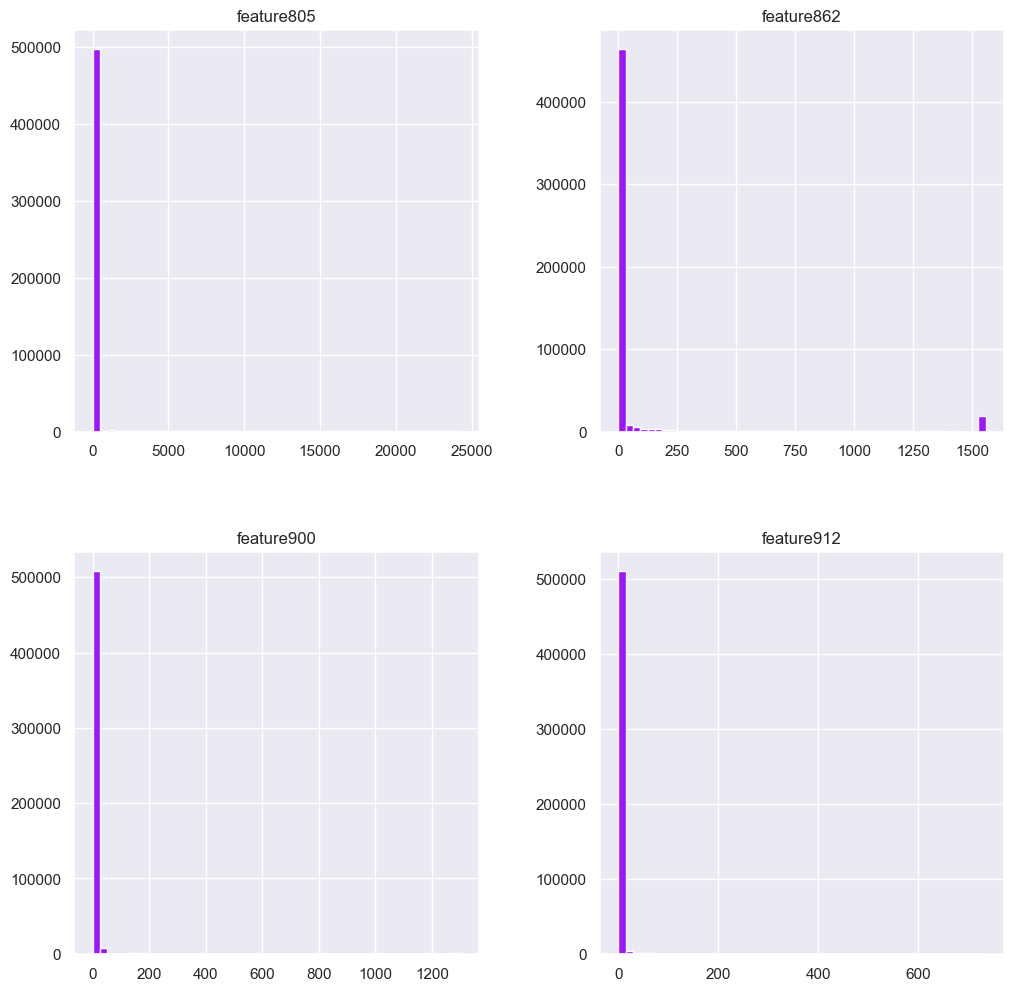

In [45]:
df[df.columns[(df.max() / df.quantile(q=0.9) < np.inf) & (df.max() / df.quantile(q=0.9) > 4.5)]].iloc[:, 50:54].hist(bins=50)
plt.show()

🟣 

Вычтя такие колонки из найденных нами "категориальных", получим итоговый список возможных категориальных признаков

In [46]:
cat_cols_final = cat_cols.difference(set(df.columns[(df.max() / df.quantile(q=0.9) < np.inf) & (df.max() / df.quantile(q=0.9) > 3)]))

In [47]:
len(cat_cols_final)

65

🟣 

До этого мы не исследовали колонки их двух значений, одно из которых равно 0. С наибольшей вероятностью они могут быть отнесены к категориальным бинарным признакам

In [48]:
# посчитаем количество таких предположительно категориальных признаков

len(df.columns[df.nunique() == 2])

146

🟣 

Подойдем к поиску категориальных признаков с другой стороны и посмотрим распределние столбцов по % значений, равных 0

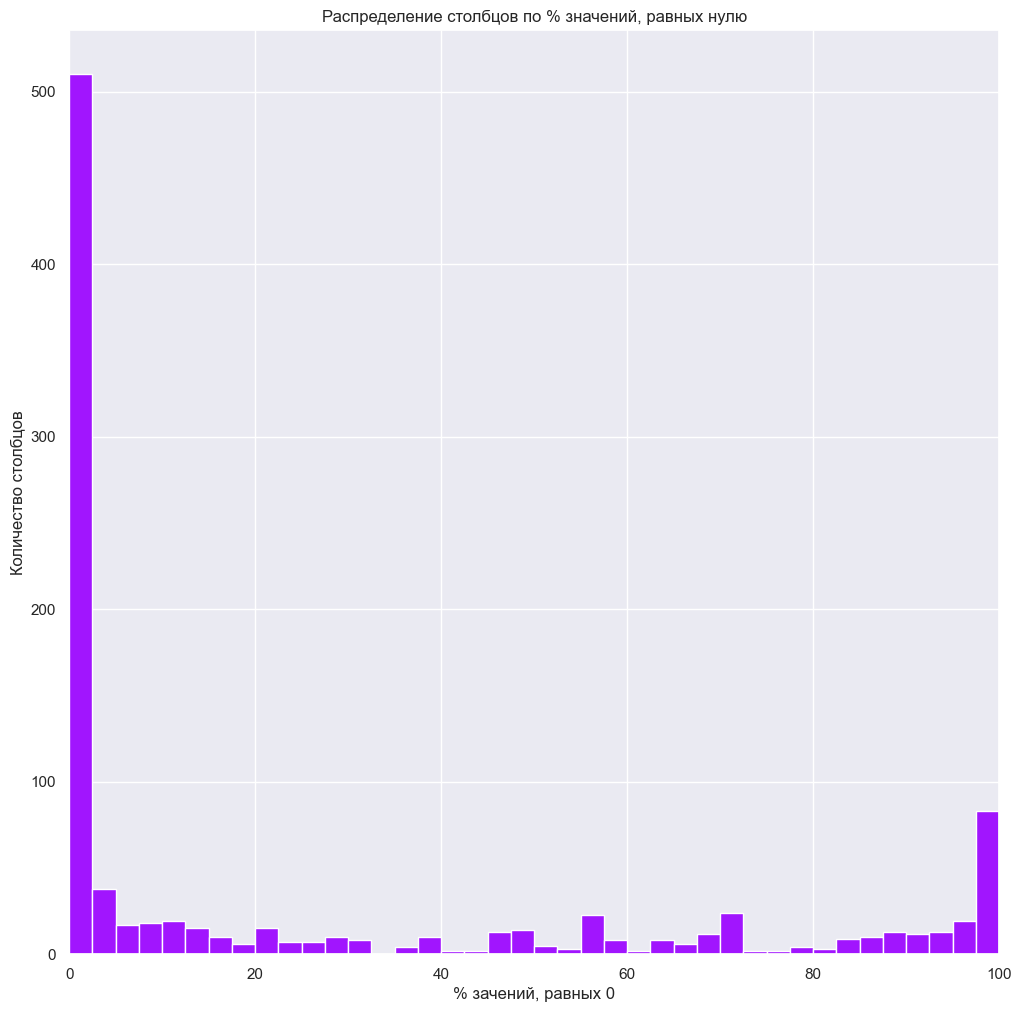

In [49]:
plt.hist((df.shape[0] - df[df != 0].count()) / df.shape[0] * 100, bins = 40, )
plt.title('Распределение столбцов по % значений, равных нулю')
plt.xlabel('% зачений, равных 0')
plt.ylabel('Количество столбцов')
plt.xlim(0, 100)
plt.show()

🟣 

Из графика видно, что у ~600 столбцов доля "ненулевых "значений находится в интервале от 0 до 10%

In [50]:
# посмотрим пересечение множества с низкой вариативностью и низкой долей нулей и найдем количество

low_unique_values_count_zeros = \
    set(df.columns[(df.shape[0] - df[df != 0].count()) / df.shape[0] <= 0.1].to_list()) & \
    set((df.nunique()[(df.nunique() <= 500)]).index.to_list())

len(low_unique_values_count_zeros)

236

🟣 

В результате анализа признаков по разным экспериментам с количеством уникальных значений, количеством нулей, статистикой колонок и распределениями, были найдены следуюшие группы колонок, потенциально являющиеся категориальными:
- 148 бинарных столбца (binar)
- 236 колонки с низкой долей нулей и количеством уникальных значений (low_unique_values_count_zeros)
- 65 колонок колонок с порогово низкой долей уникальных значений в колонке без учета строк с 0 (cat_cols_final)

## Исследование корреляции признаков

🟣 

Взаимная высокая корреляция некоторых признаков между собой является еще одной особенностью наших даных

Рассмотрим хитмап корреляции фич

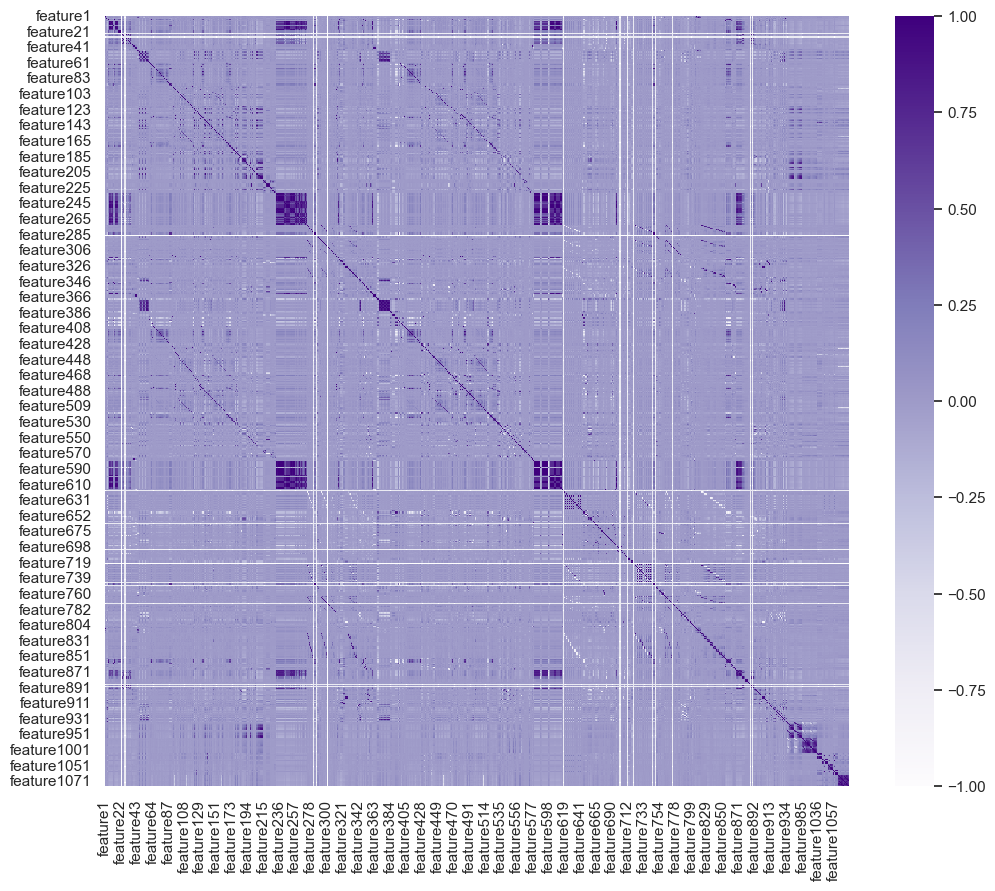

In [51]:
corr = df.sample(10000).iloc[:, :].corr()
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(corr, cmap='Purples')
plt.show()

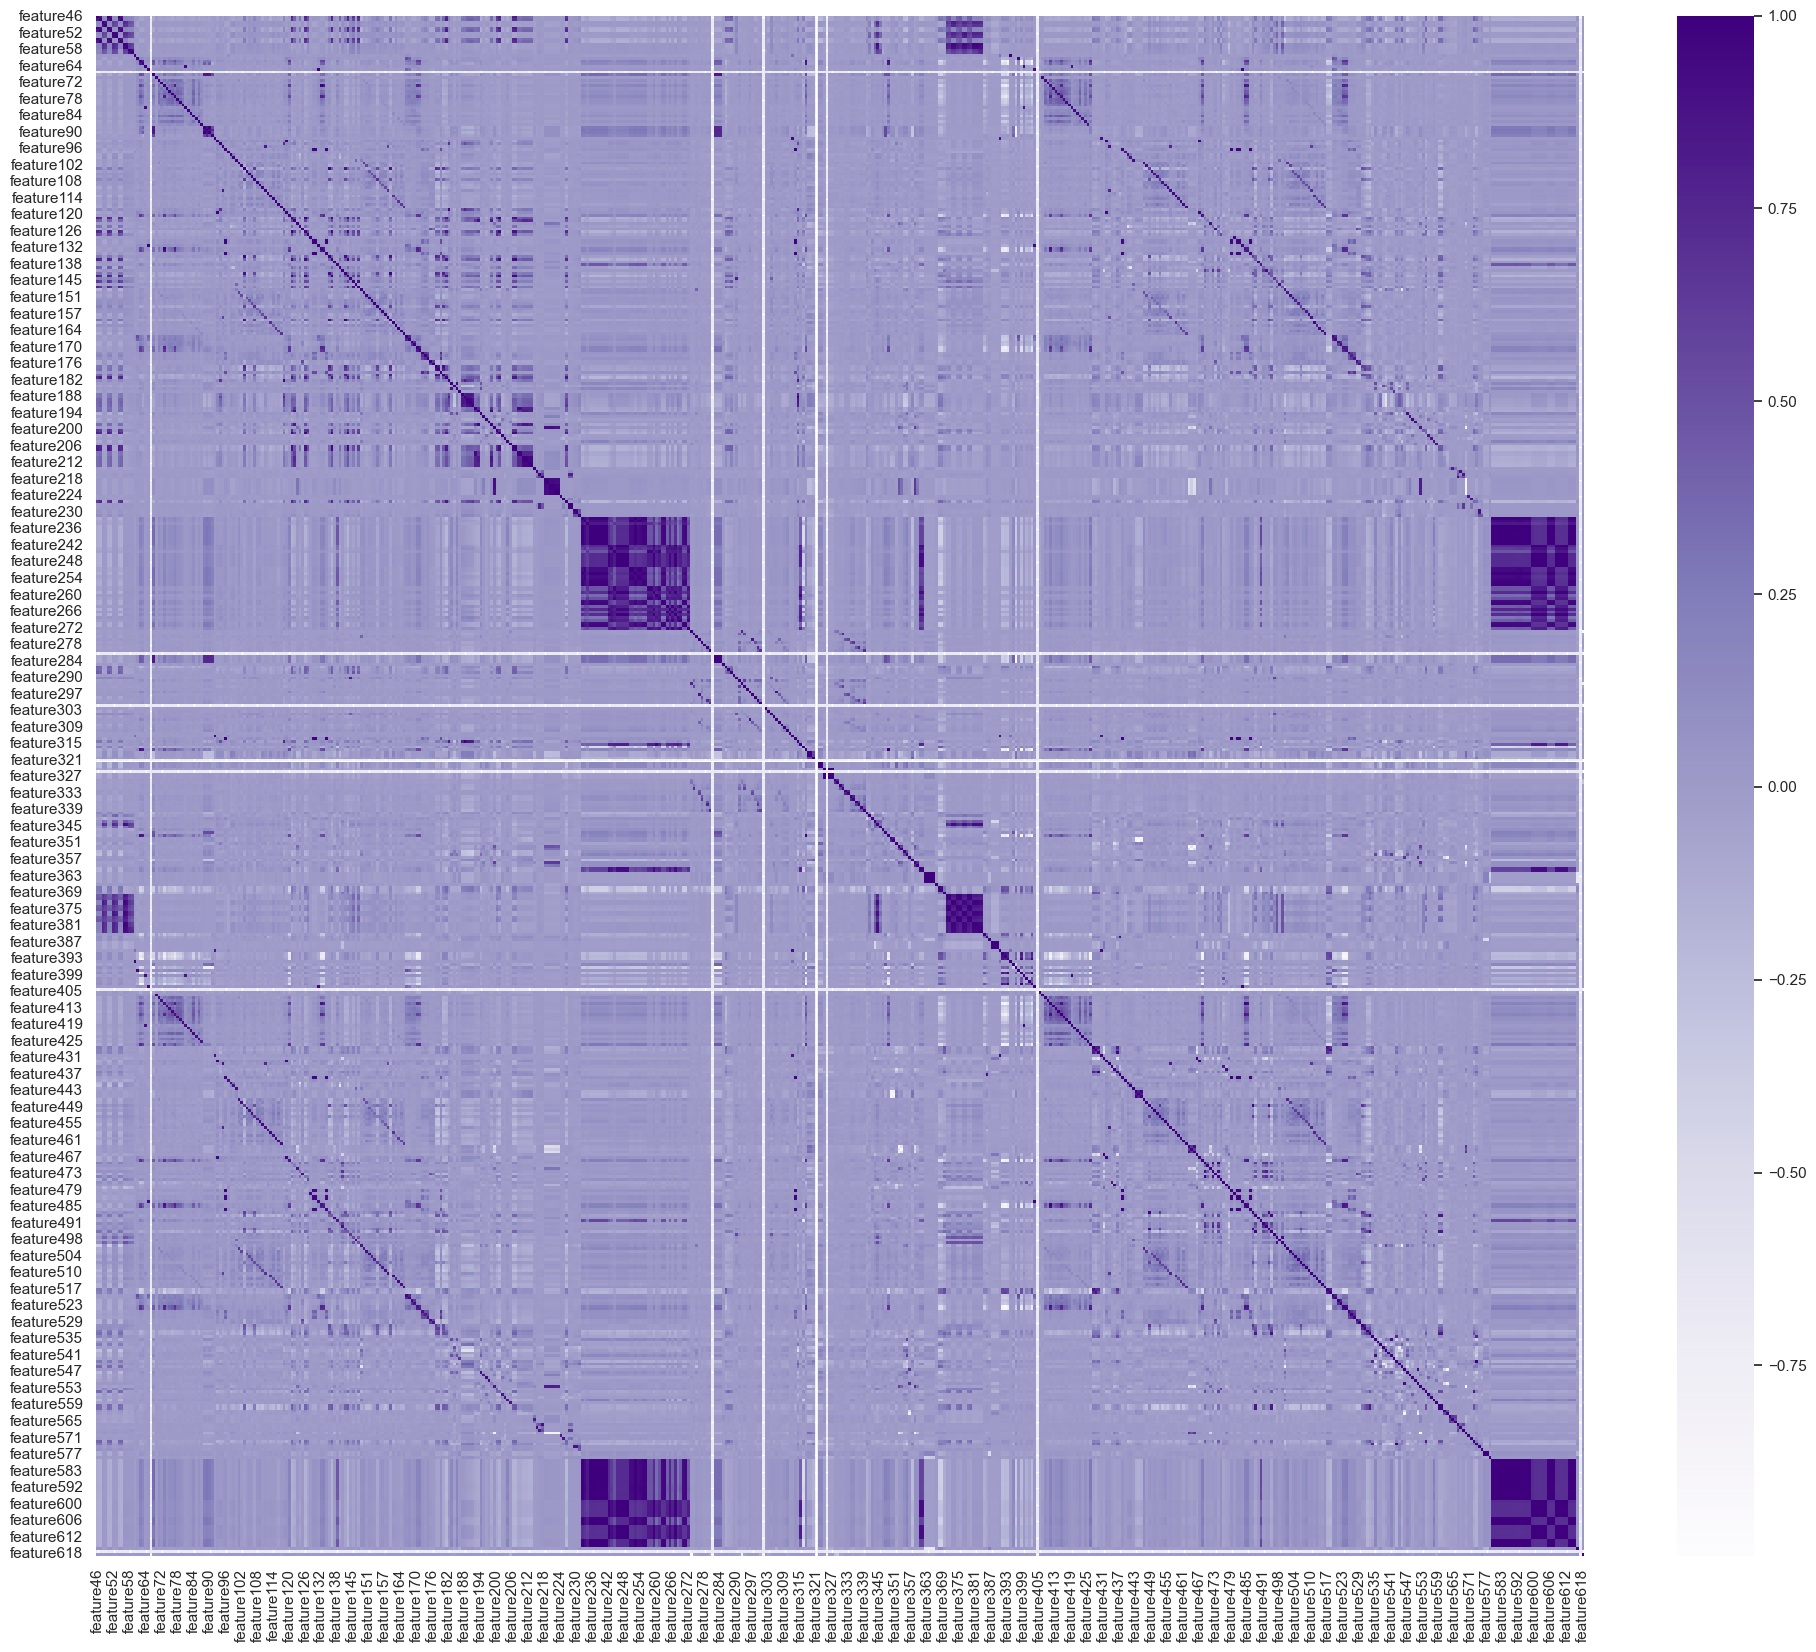

In [52]:
corr = df.sample(10000).loc[:, 'feature46':'feature618'].drop(['feature587', 'feature588', 'feature589', 'feature597', 'feature599'], axis=1).corr()
sns.set(rc={'figure.figsize':(24,20)})
sns.heatmap(corr, cmap='Purples')
plt.show()

🟣 

По хитмапу можно заметить повторяющиеся паттерны. Например, корреляция фич 46-272 самих собой очень похожа на корреляцию этих же фич с фичами 365-615. При этом паттерны не 1 в 1, и второй интервал словно разрежен другими, не относящимися к совпадаемым интервалам, признаками

In [53]:
df.sample(1000, random_state=42).loc[:, 'feature46':'feature59'].head()

feature46  feature47  feature48  feature49  feature50  feature51  \
id                                                                         
369618     546040     624430          0          0     545324     622757   
598784     148164     257138          0          0     148831     256913   
626953     367798     539748          0          0     365896     537647   
118540      96389     130098          0          0      97243     130562   
99334      334749     515466          0          0     334639     514172   

        feature52  feature53  feature54  feature55  feature56  feature57  \
id                                                                         
369618          0          0     530373     608514          0          0   
598784          0          0     143100     251296          0          0   
626953        882       2280     355113     525704          0          0   
118540          0          0      93067     127550          0          0   
99334           0          0     324535     502769          0          0   

        feature58  feature59  
id                            
369618          0          0  
598784          0          0  
626953          0          0  
118540          0          0  
99334           0          0

In [54]:
df.sample(1000, random_state=42).loc[:, 'feature370':'feature383'].head()

feature370  feature371  feature372  feature373  feature374  \
id                                                                   
369618          92         235           0           0          92   
598784          54         153           0           0          54   
626953          39         109           0           0          38   
118540          15          44           0           0          15   
99334            3          17           0           0           3   

        feature375  feature376  feature377  feature378  feature379  \
id                                                                   
369618         236           0           0          92         236   
598784         154           0           0          54         154   
626953         106           1           4          38         106   
118540          45           0           0          15          45   
99334           18           0           0           3          18   

        feature380  feature381  feature382  feature383  
id                                                      
369618           0           0           0           0  
598784           0           0           0           0  
626953           0           0           0           0  
118540           0           0           0           0  
99334            0           0           0           0

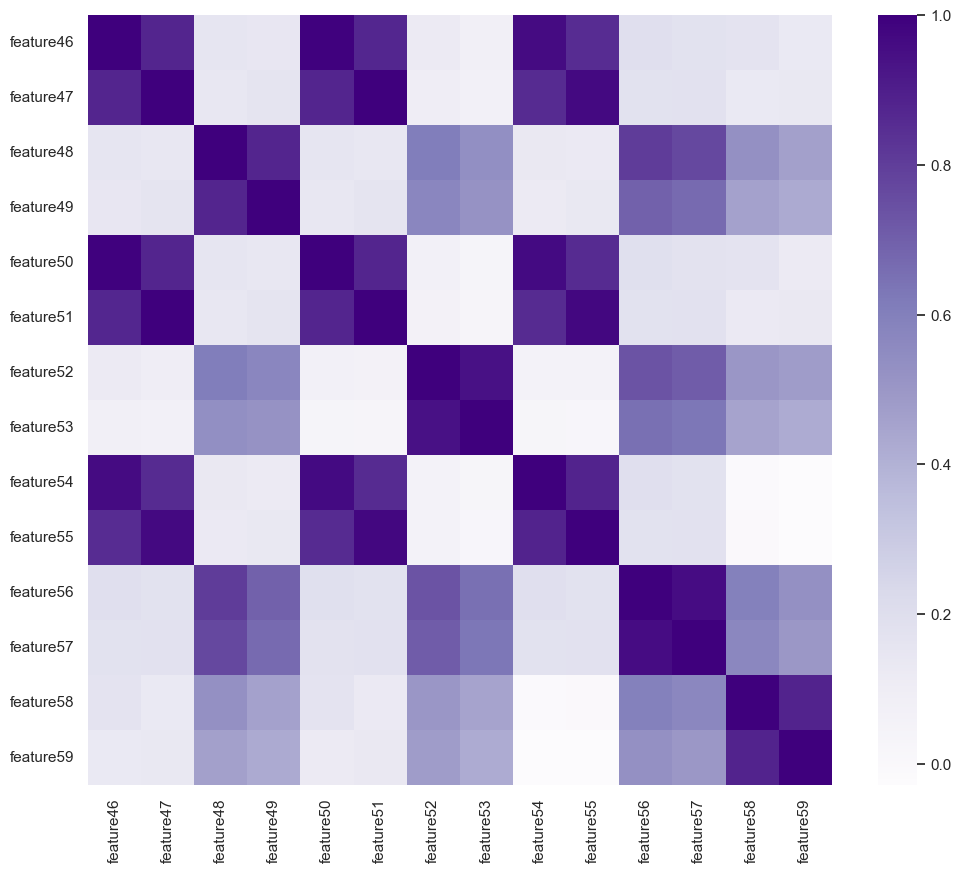

In [55]:
corr = df.sample(1000).loc[:, 'feature46':'feature59'].corr()
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(corr, cmap='Purples')
plt.show()

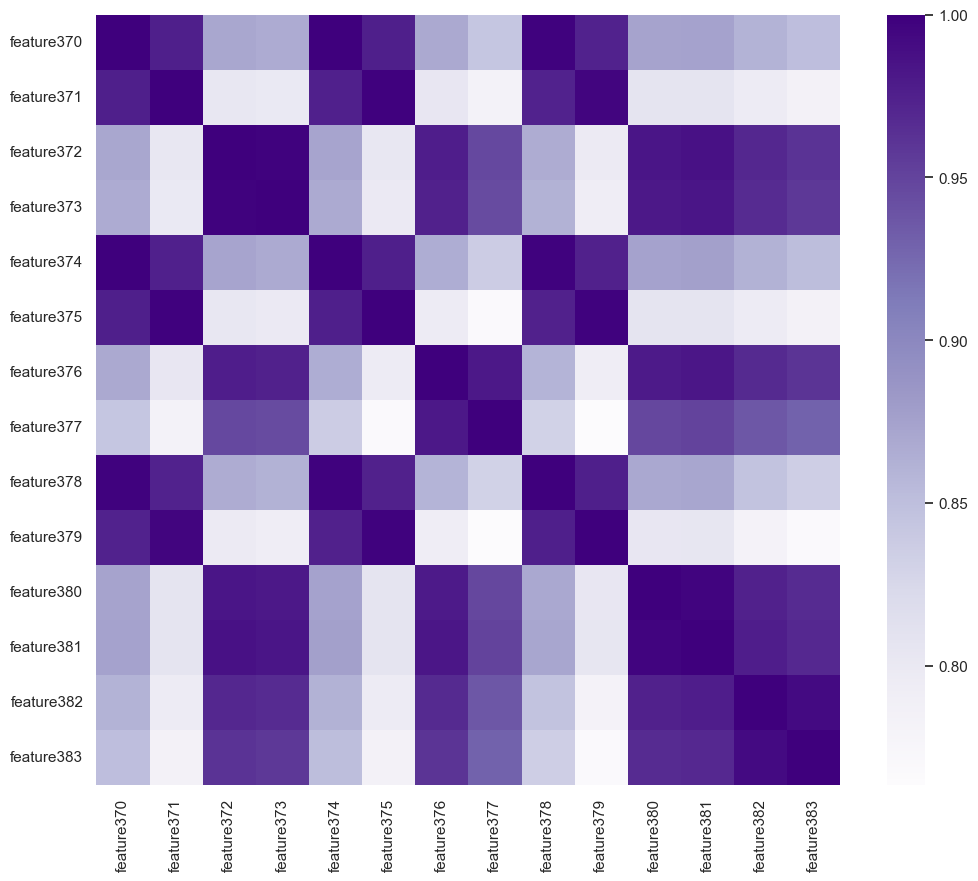

In [56]:
corr = df.sample(1000).loc[:, 'feature370':'feature383'].corr()
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(corr, cmap='Purples')
plt.show()

In [57]:
df.sample(n=10, random_state=420).loc[:, 'feature46':'feature59']

feature46  feature47  feature48  feature49  feature50  feature51  \
id                                                                         
122848       5073      15660          0          0       5411      16350   
196773      62948      47000          0          0      63843      47826   
86774      406092     473181          0          0     405793     471994   
4491       378307     553208          0          0     378071     551749   
36442       93674     136445        884       1060      94531     136899   
57753      288305     295931          0          0     288427     295505   
387212     441097     479187          0          0     440666     477982   
290980     538385     604840          0          0     537696     603231   
492886     266462     399385          0          0     266664     398498   
80584         619      19115          0          0        686      19812   

        feature52  feature53  feature54  feature55  feature56  feature57  \
id                                                                         
122848          0          0       5041      15864          0          0   
196773          0          0      60702      46691          0          0   
86774           0          0     394182     461542          0          0   
4491            0          0     367039     539381          0          0   
36442           0          0      87359     132564          0          0   
57753           0          0     279337     289144          0          0   
387212          0          0     428248     467423          0          0   
290980          0          0     522957     589487          0          0   
492886          0          0     258071     389850          0          0   
80584           0          0          0          0          0          0   

        feature58  feature59  
id                            
122848          0          0  
196773          0          0  
86774           0          0  
4491            0          0  
36442           0          0  
57753           0          0  
387212          0          0  
290980          0          0  
492886          0          0  
80584         603      12472

In [58]:
df.sample(n=10, random_state=420).loc[:, 'feature370':'feature383']

feature370  feature371  feature372  feature373  feature374  \
id                                                                   
122848           6          14           0           0           6   
196773          33          51           0           0          33   
86774           22          52           0           0          22   
4491           175         596           0           0         175   
36442           31          70           1           1          31   
57753           49         144           0           0          49   
387212          91         210           0           0          91   
290980          30          71           0           0          30   
492886          22         126           0           0          22   
80584            1           9           0           0           1   

        feature375  feature376  feature377  feature378  feature379  \
id                                                                   
122848          15           0           0           6          15   
196773          52           0           0          33          52   
86774           53           0           0          22          53   
4491           597           0           0         175         597   
36442           71           0           0          30          70   
57753          145           0           0          49         145   
387212         211           0           0          91         211   
290980          72           0           0          30          72   
492886         127           0           0          22         127   
80584           10           0           0           0           0   

        feature380  feature381  feature382  feature383  
id                                                      
122848           0           0           0           0  
196773           0           0           0           0  
86774            0           0           0           0  
4491             0           0           0           0  
36442            0           0           0           0  
57753            0           0           0           0  
387212           0           0           0           0  
290980           0           0           0           0  
492886           0           0           0           0  
80584            0           0           1          10

🟣 

При сравнении маленьких квадратиков подтверждается высокая степень пожести интервалов: одинаковый паттерн хитмапа, совпадение нулевых ячеек. При этом масштабы данных совершенно разные, и способ переложить одни значения на другие неочевиден

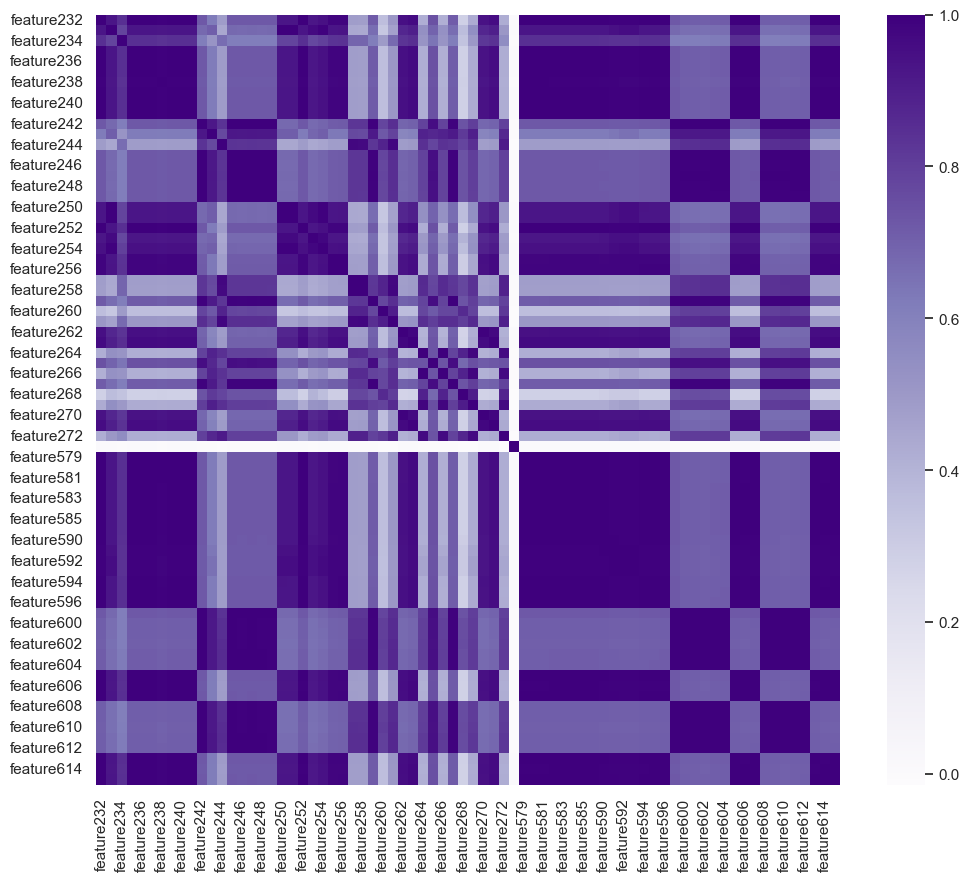

In [59]:
col_list = list(df.loc[:, 'feature232':'feature273'].columns) + list(df.loc[:, 'feature579':'feature615'].columns)

corr = df.sample(100000).loc[:, col_list].drop(['feature587', 'feature588', 'feature589', 'feature597', 'feature599'], axis=1).corr()
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(corr, cmap='Purples')
plt.show()

In [60]:
df.sample(n=10, random_state=420).loc[:, 'feature232':'feature272']

feature232  feature233  feature234  feature235  feature236  \
id                                                                   
122848           4       71970      170494           3           4   
196773           4       71970      170494           3           4   
86774            0        3201           0           0           0   
4491             0           0      169695           0           0   
36442            0           0           0           0           0   
57753            0           0       15863           0           0   
387212           4       71970      170494           3           4   
290980           0           0           0           0           0   
492886           0           0       93624           0           0   
80584            4       71970      170494           3           4   

        feature237  feature238  feature239  feature240  feature241  \
id                                                                   
122848           2        5553          16          15          11   
196773           2        5553          16          15          11   
86774            0        3878           0           0           0   
4491             0           0           0           0           0   
36442            0           0           0           0           0   
57753            0           0           0           0           0   
387212           2        5553          16          15          11   
290980           0           0           0           0           0   
492886           0           0           0           0           0   
80584            2        5553          16          15          11   

        feature242  feature243  feature244  feature245  feature246  \
id                                                                   
122848           2       66558      156457           1         940   
196773           2       66558      156457           1         940   
86774            0        7956           0           0           0   
4491             0           0      154634           0           0   
36442            0           0           0           0           0   
57753            0           0       36057           0           0   
387212           0           0           0           0           0   
290980           0           0           0           0           0   
492886           0           0       59359           0           0   
80584            0           0           0           0           0   

        feature247  feature248  feature249  feature250  feature251  \
id                                                                   
122848          32         971        1525       71927       71969   
196773          32         971        1525       71927       71969   
86774            0           0           0        3197        3203   
4491             0           0           0           0           0   
36442            0           0           0           0           0   
57753            0           0           0           0           0   
387212           0           0           0       71927       71969   
290980           0           0           0           0           0   
492886           0           0           0           0           0   
80584            0           0           0       71927       71969   

        feature252  feature253  feature254  feature255  feature256  \
id                                                                   
122848         495       30723       20014       15773       12949   
196773         495       30723       20014       15773       12949   
86774            0       18495       12540       13208       10887   
4491             0           0           0           0           0   
36442            0           0           0           0           0   
57753            0           0           0           0           0   
387212         495       30723       20014       15773       12949   
290980        

In [61]:
df.sample(n=10, random_state=420).loc[:, 'feature579':'feature615'].drop(['feature587', 'feature588', 'feature589', 'feature597', 'feature599'], axis=1)

feature579  feature580  feature581  feature582  feature583  \
id                                                                   
122848           6           6           6           2           2   
196773           6           6           6           2           2   
86774            1           1           1           0           0   
4491             0           0           0           0           0   
36442            0           0           0           0           0   
57753            0           0           0           0           0   
387212           6           6           6           2           2   
290980           0           0           0           0           0   
492886           0           0           0           0           0   
80584            6           6           6           2           2   

        feature584  feature585  feature586  feature590  feature591  \
id                                                                   
122848           8          15          11          10          10   
196773           8          15          11          10          10   
86774            0           0           0           0           1   
4491             0           0           0           0           0   
36442            0           0           0           0           0   
57753            0           0           0           0           0   
387212           8          15          11          10          10   
290980           0           0           0           2           2   
492886           0           0           0           0           0   
80584            8          15          11          10          10   

        feature592  feature593  feature594  feature595  feature596  \
id                                                                   
122848           6           6          90         330         281   
196773           6           6          90         330         281   
86774            1           1           5          29          29   
4491             0           0           0           0           0   
36442            0           0           0           0           0   
57753            0           0           0           0           0   
387212           6           6          90         330         281   
290980           0           0           0           0           0   
492886           0           0           0           0           0   
80584            6           6          90         330         281   

        feature598  feature600  feature601  feature602  feature603  \
id                                                                   
122848          12         117         116         122          35   
196773          12         117         116         122          35   
86774            0           2           2           2           0   
4491             0          21          21          23           2   
36442            0           0           0           0           0   
57753            0           0           0           1           1   
387212           0           0           0           0           0   
290980           0           1           1           1           0   
492886           0           1           1           2           1   
80584            0           0           0           0           0   

        feature604  feature605  feature606  feature607  feature608  \
id                                                                   
122848          35         173        1941        1608         115   
196773          35         173        1941        1608         115   
86774            0           0           0           0           3   
4491             2           0           0           0          21   
36442            0           0           0           0           0   
57753            1           0           0           0           0   
387212           0         173        1941        1608           0   
290980        

🟣 

С другими участками хитмапа дела еще сложнее: паттерны менее похожие и последовательные колонки не перекладываются друг на друга

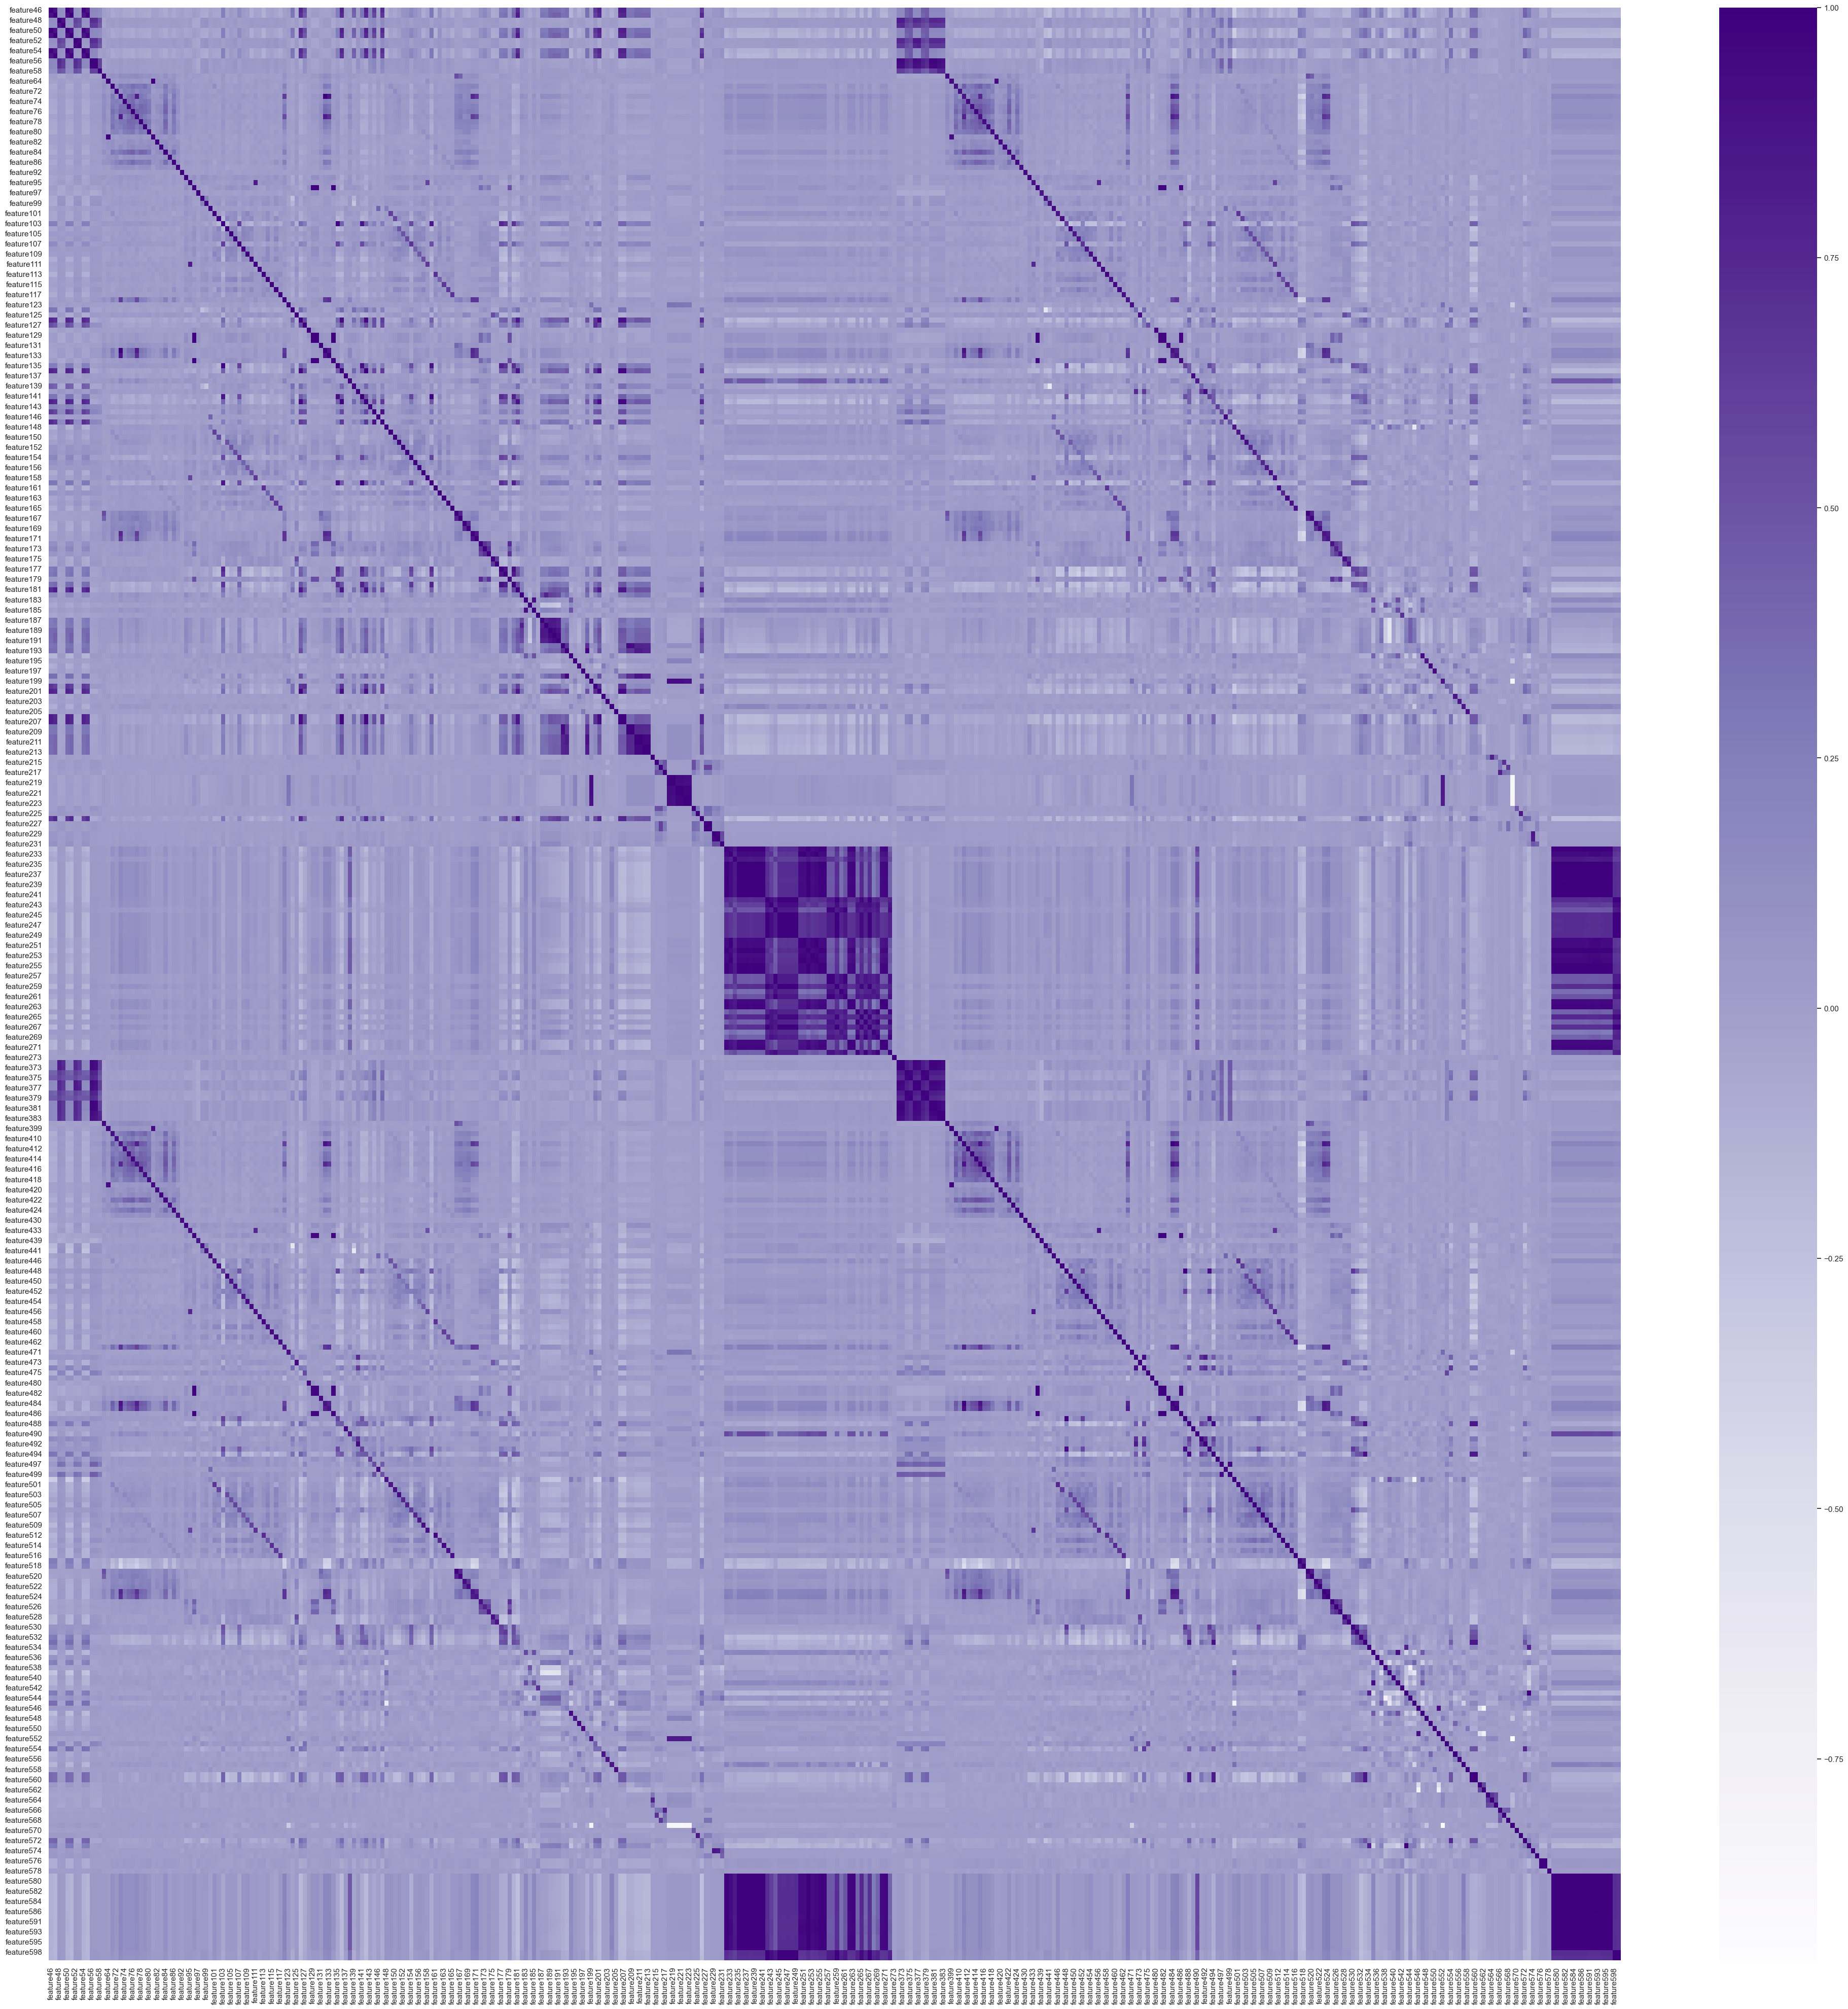

In [62]:
col_list = list(df.loc[:, 'feature46':'feature273'].columns) + list(df.loc[:, 'feature372':'feature600'].columns)

corr = df.sample(10000).loc[:, col_list] \
    .drop([
    'feature59','feature60','feature62','feature63','feature65','feature66','feature67','feature70','feature88','feature89','feature90','feature91','feature94','feature118','feature119','feature121','feature122',
    'feature587', 'feature588', 'feature589', 'feature597', 'feature599', 
    'feature384','feature385','feature385','feature386','feature387','feature388','feature389','feature390','feature391','feature392','feature393','feature394','feature395','feature396','feature398','feature400',
    'feature401','feature402','feature403','feature404','feature404','feature405','feature408','feature426','feature427','feature428','feature429','feature431','feature434','feature435','feature436','feature437',
    'feature443','feature444','feature445','feature463','feature464','feature465','feature466','feature467','feature469','feature470','feature477','feature478','feature479'
    ], axis=1) \
    .corr()

sns.set(rc={'figure.figsize':(50,50)})
sns.heatmap(corr, cmap='Purples')
plt.show()

🟣 

Была попытка удалить разрежающие столбцы, получить два совпадающих промежутка фич, но пока такое представляется сомнительной трудоемкой задачей. Текузий вывод - при отборе фич иметь в виду высокую корреляцию отдельных признаков и целых групп признаков между собоой

🟣 

Еще в прошлом разделе были обнаружено последовательно идущие колонки с одинаковым количеством уникальных значений. Найдем и рассмотрим некоторые группы таких последовательных признаков

In [63]:
# группы последовательных признаков с одинаковым количествомвом значений

l00 = ['feature1', 'feature2']     # одинаковое количество, но разное распределение
l01 = ['feature19', 'feature20']
l02 = ['feature210', 'feature211']
l03 = ['feature212', 'feature213']
l04 = ['feature220', 'feature221']
l05 = ['feature222', 'feature223']
l06 = ['feature227', 'feature228']
l07 = ['feature322', 'feature323']
l08 = ['feature589', 'feature590']
l09 = ['feature603', 'feature604']
l10 = ['feature611', 'feature612']
l11 = ['feature721', 'feature722']
l12 = ['feature746', 'feature747']
l13 = ['feature890', 'feature891'] # близко, но неидентично по распределению
l14 = ['feature916', 'feature917'] # близко, но неидентично по распределению
l15 = ['feature918', 'feature919'] # одинаковое количество, но разное распределение
l16 = ['feature1038', 'feature1039', 'feature1040', 'feature1041']
l17 = ['feature1045', 'feature1046', 'feature1047', 'feature1048']
l18 = ['feature1059', 'feature1060', 'feature1061', 'feature1062']

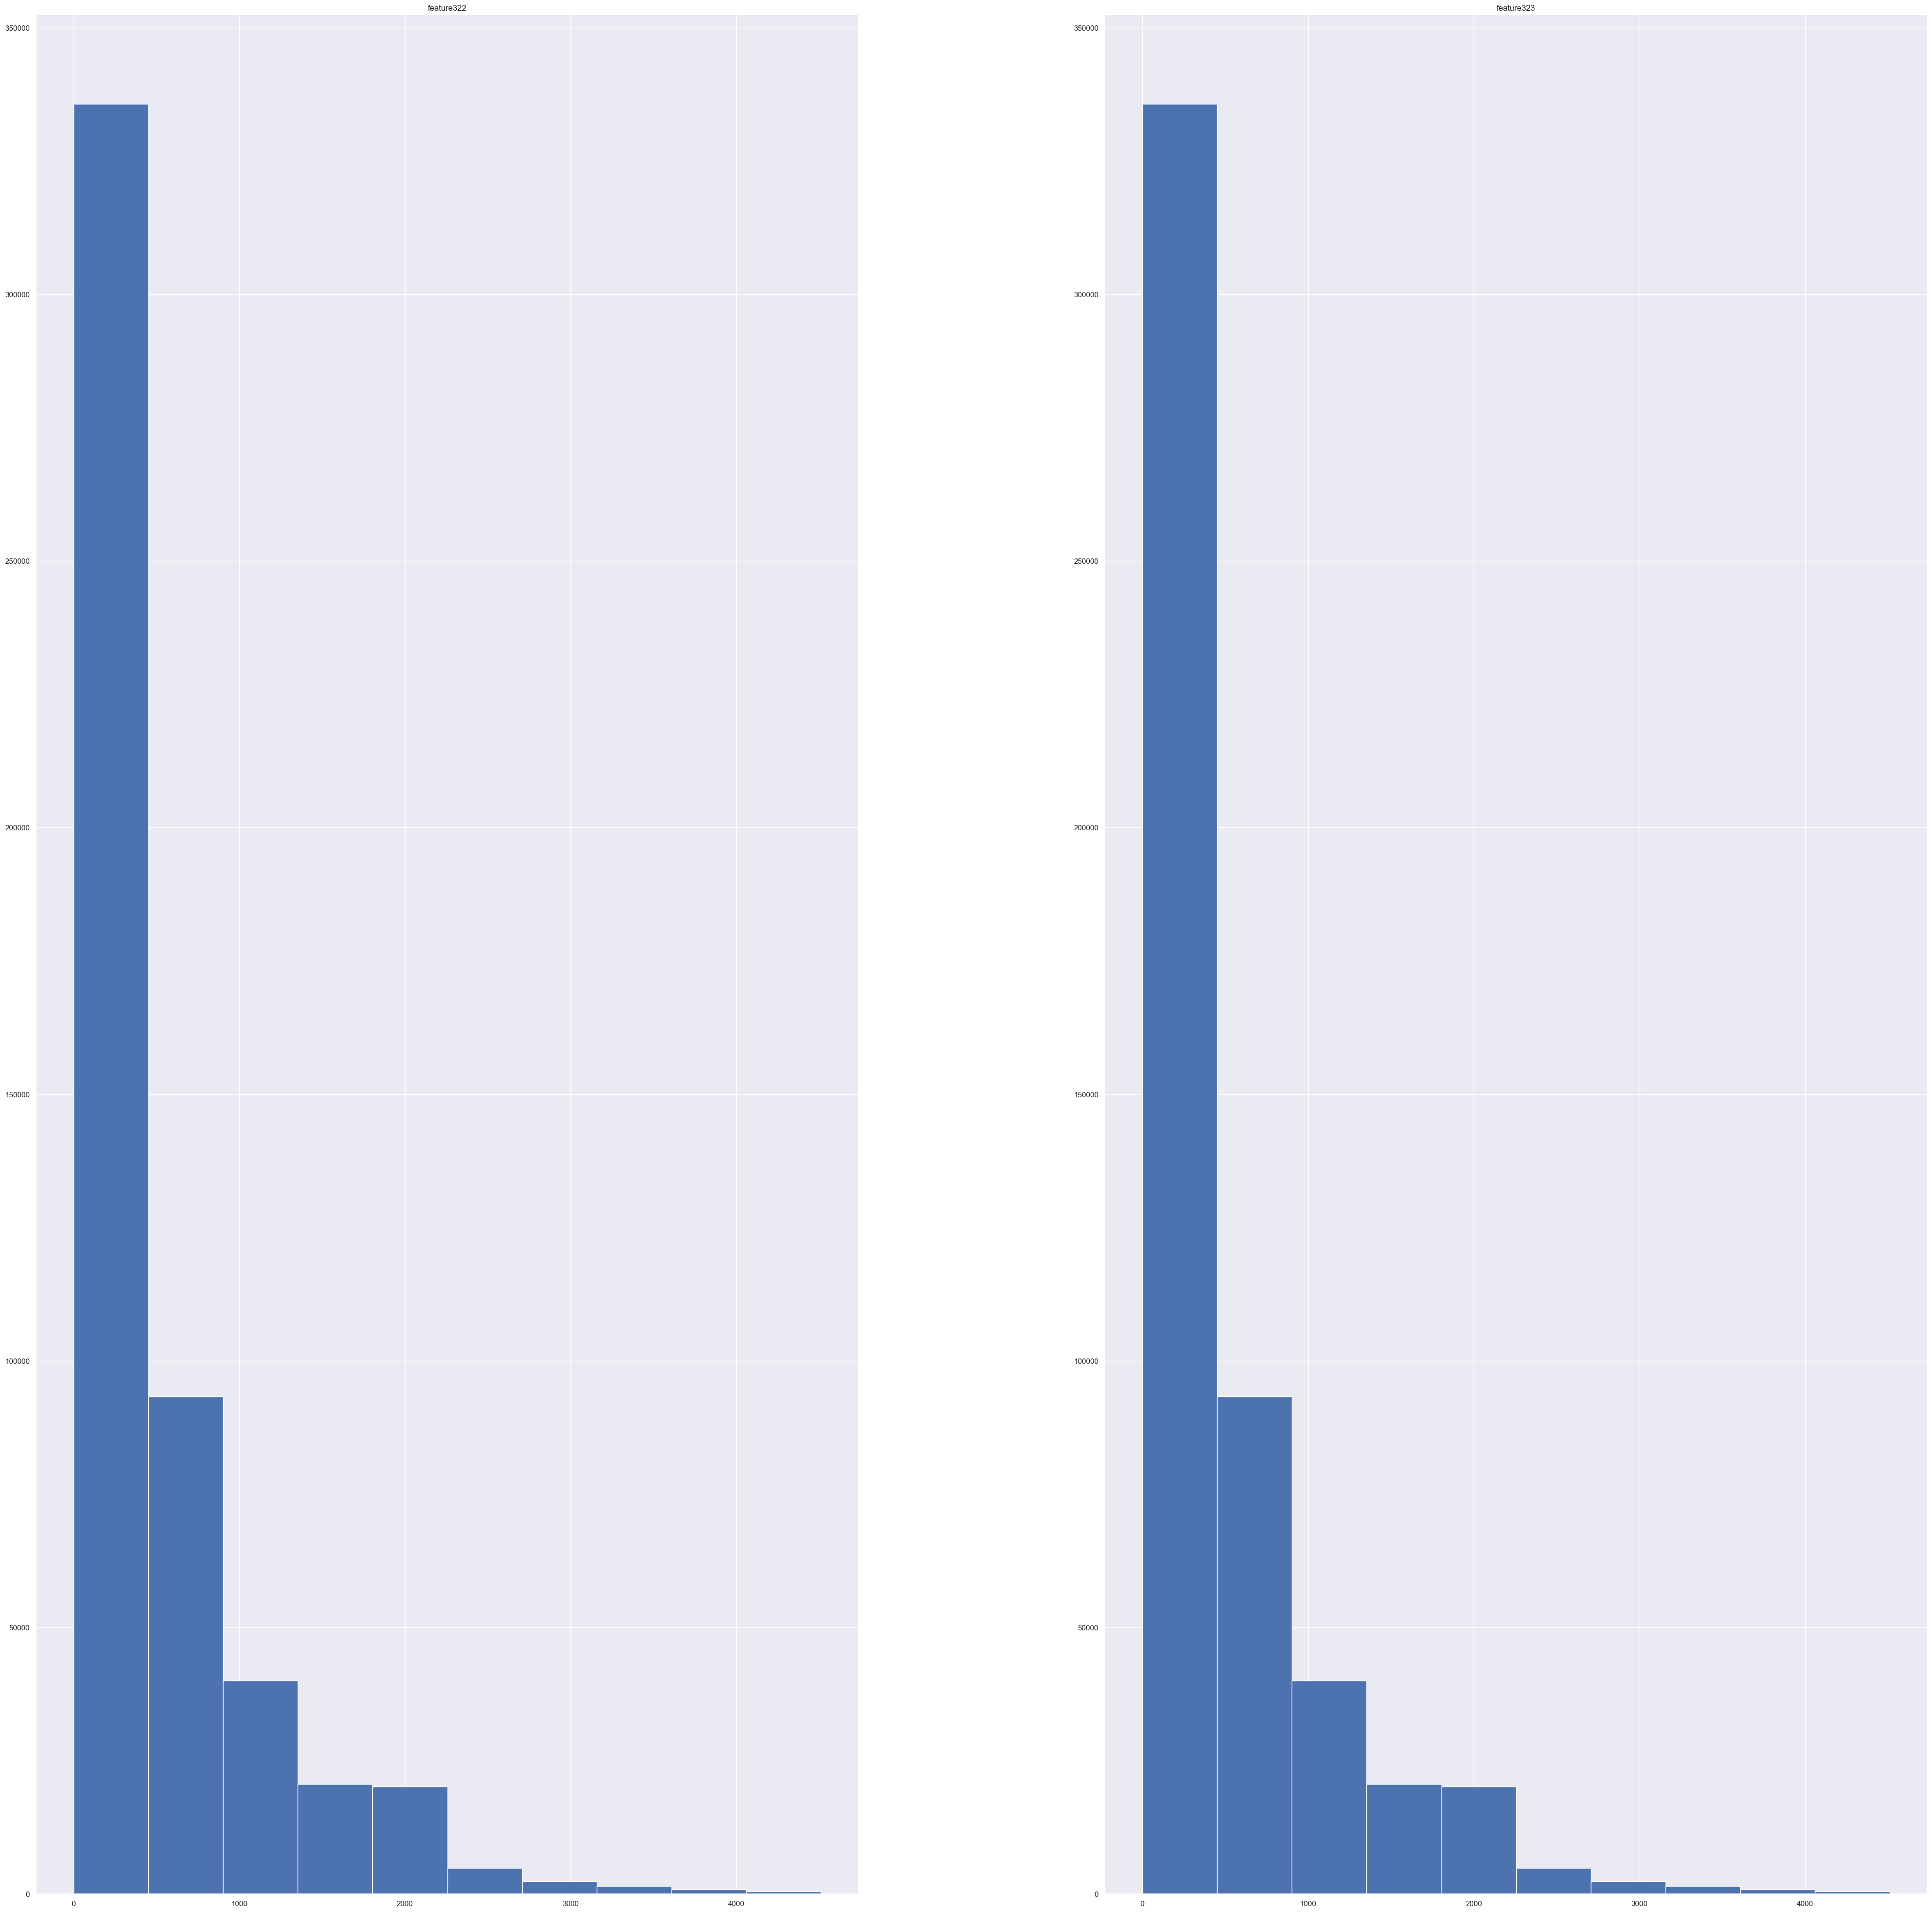

In [64]:
df[l07].hist(bins=10)
plt.show()

In [65]:
df[l07].corr()

feature322  feature323
feature322         1.0         1.0
feature323         1.0         1.0

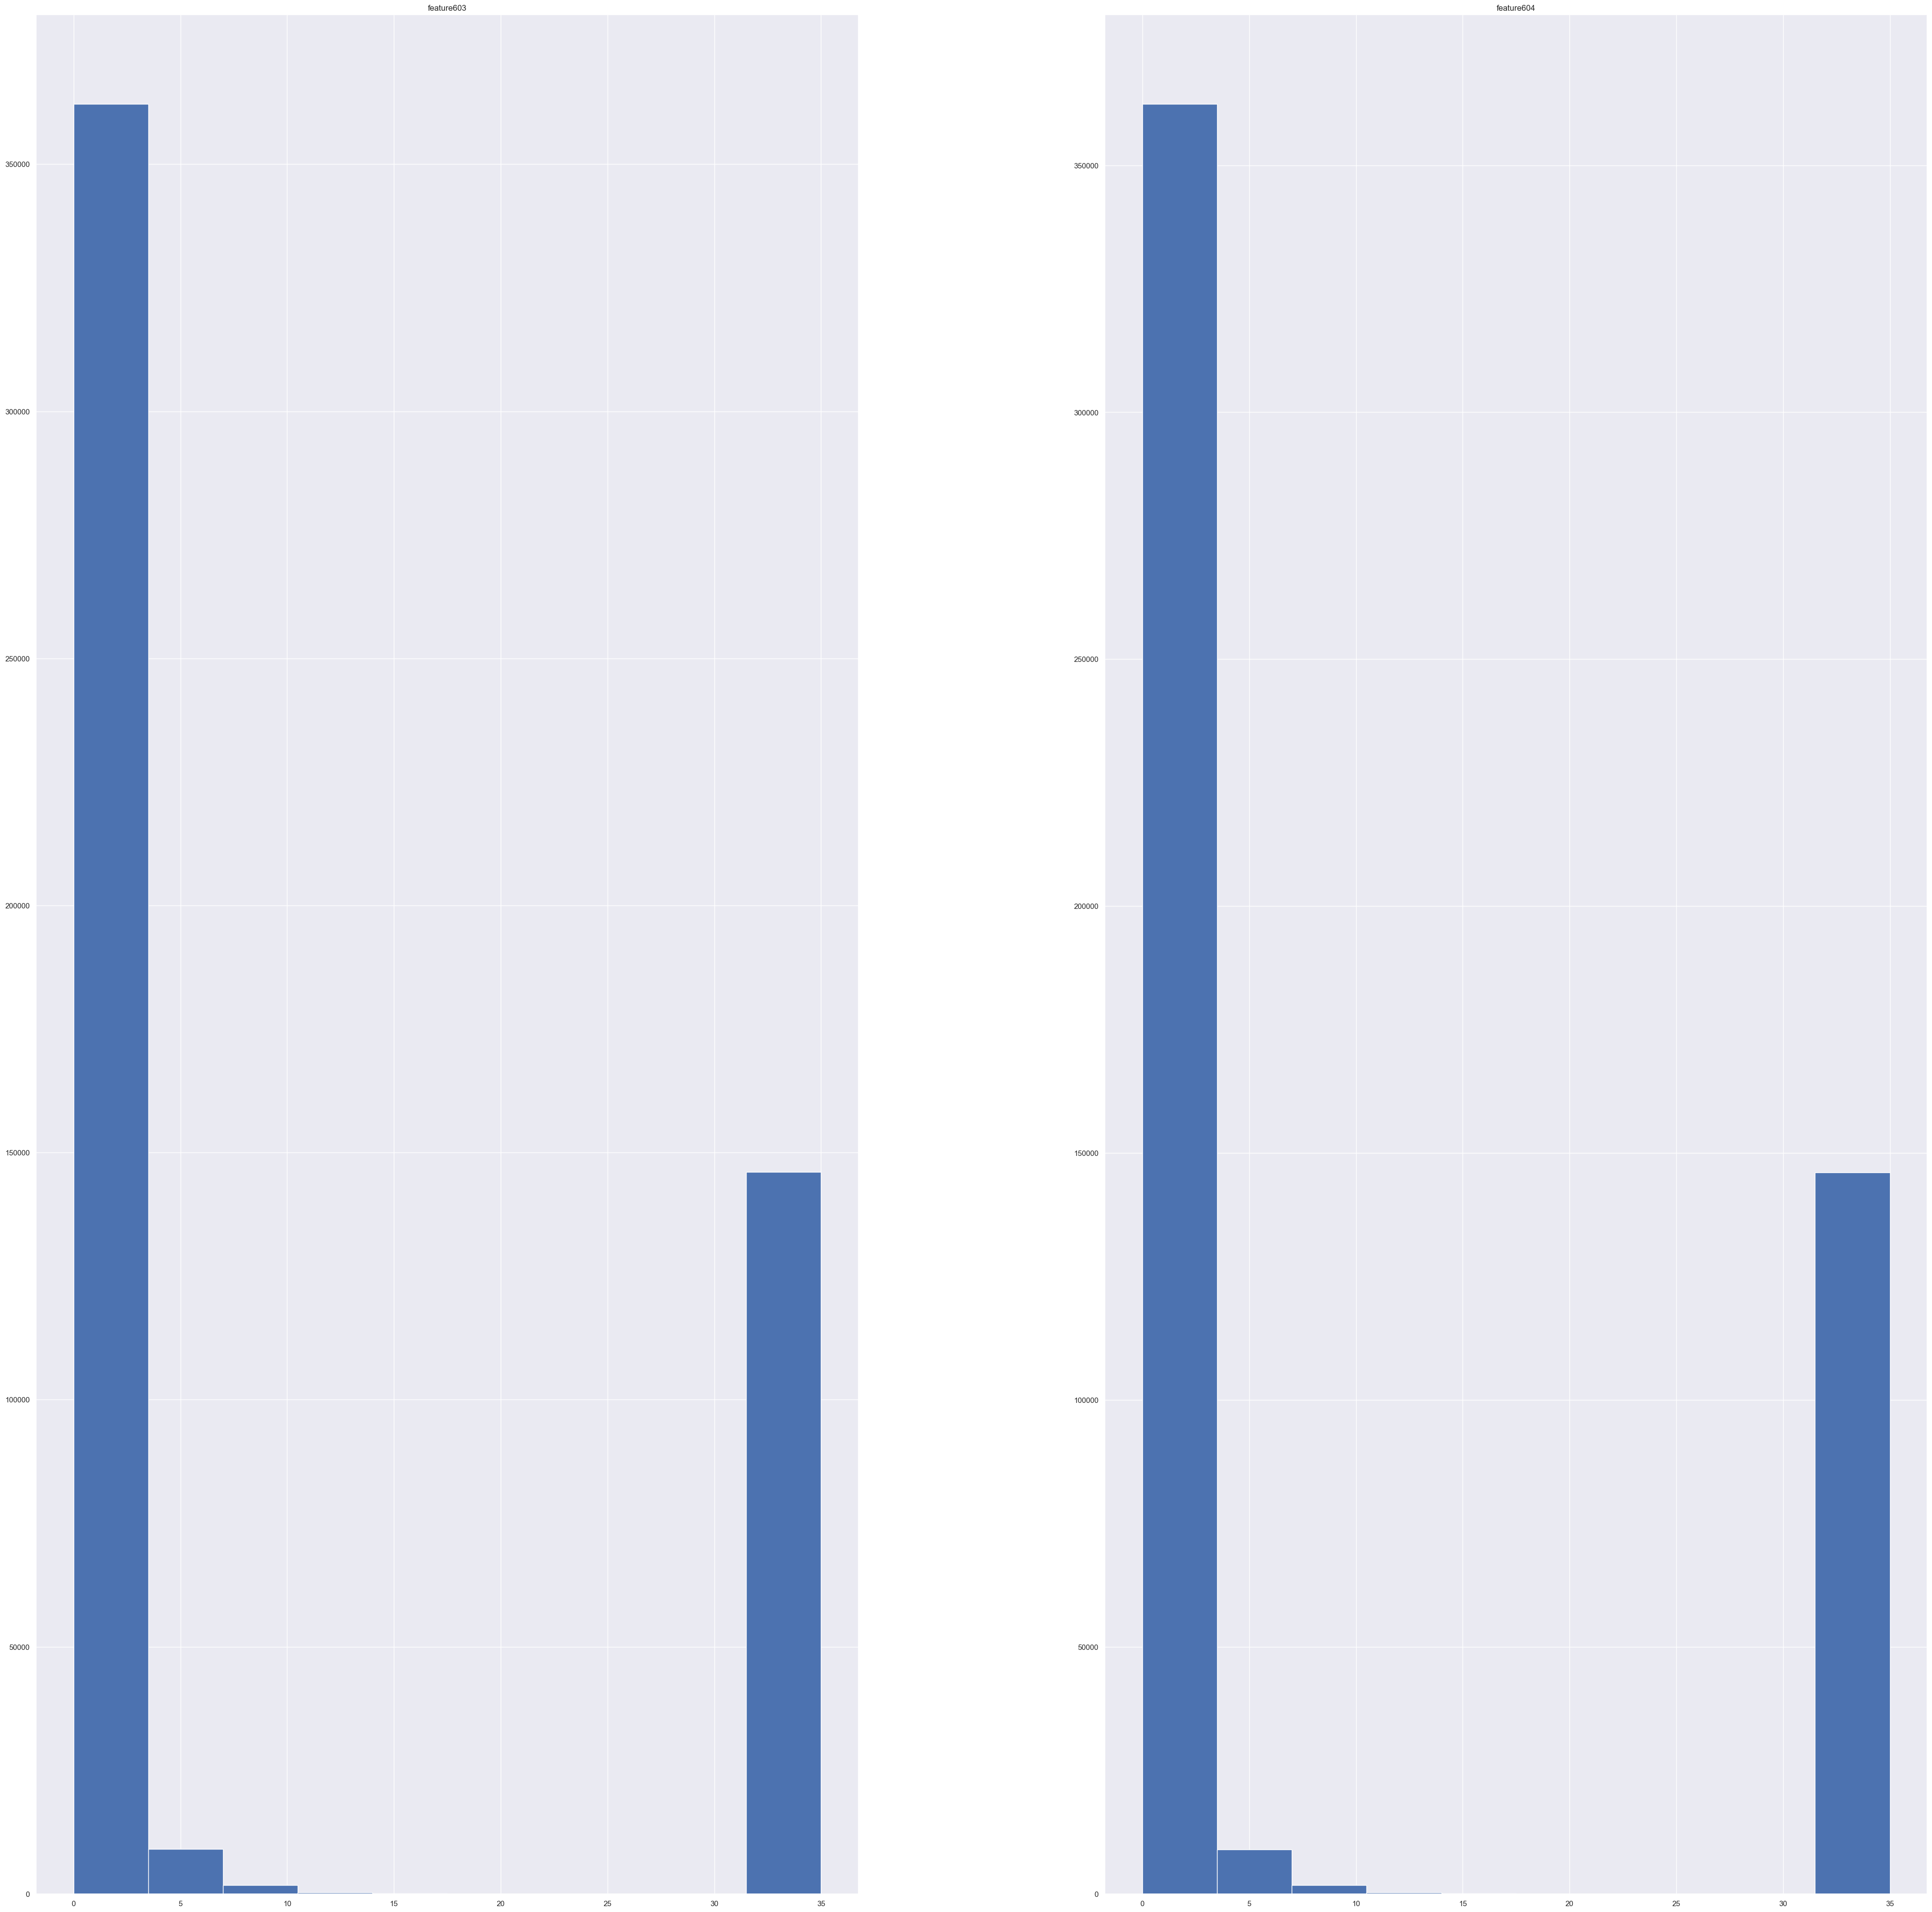

In [66]:
df[l09].hist(bins=10)
plt.show()

In [67]:
df[l09].corr()

feature603  feature604
feature603    1.000000    0.999975
feature604    0.999975    1.000000

Как видно по графикам и расчетам корреляции, у нас есть несколько групп идентичных последовательных колонок. При работе с препроцессингом и обучением потребуется отбор коррелирующих фич

## END

In [68]:
columns = \
['feature1004',
'feature341',
'feature940',
'feature319',
'feature951',
'feature988',
'feature920',
'feature444',
'feature1',
'feature909',
'feature783',
'feature782',
'feature191',
'feature907',
'feature211',
'feature342',
'feature985',
'feature94',
'feature122',
'feature209',
'feature46',
'feature900',
'feature591',
'feature454',
'feature180',
'feature989',
'feature861',
'feature1036',
'feature470',
'feature928',
'feature898',
'feature226',
'feature25',
'feature358',
'feature446',
'feature893',
'feature551',
'feature755',
'feature572',
'feature497',
'feature930',
'feature922',
'feature472',
'feature504',
'feature688',
'feature1075',
'feature435',
'feature141',
'feature915',
'feature540',
'feature368',
'feature459',
'feature949',
'feature316',
'feature532',
'feature817',
'feature919',
'feature29',
'feature781',
'feature287',
'feature934',
'feature1056',
'feature89',
'feature986',
'feature491',
'feature506',
'feature489',
'feature997',
'feature340',
'feature351',
'feature182',
'feature530',
'feature715',
'feature4',
'feature918',
'feature366',
'feature854',
'feature750',
'feature917',
'feature531',
'feature554',
'feature429',
'feature405',
'feature892',
'feature335',
'feature3',
'feature286',
'feature374',
'feature777',
'feature508',
'feature488',
'feature553',
'feature810',
'feature344',
'feature154',
'feature527',
'feature820',
'feature1045',
'feature537',
'feature856',
'feature1065',
'feature188',
'feature535',
'feature12',
'feature1064',
'feature932',
'feature897',
'feature452',
'feature926',
'feature829',
'feature599',
'feature1057',
'feature393',
'feature20']

In [69]:
def get_shap_feature(X_train, y_train, X_val, classifiers):
    import numpy as np
    import pandas as pd
    import shap

    # Список для хранения результатов по каждой модели
    models_shap_values = []

    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        X_sample = shap.utils.sample(X_train, 10000)  # Выборка из 100 наблюдений
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_sample)

        # Создаем DataFrame с SHAP значениями и фильтруем значимые признаки
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'shap_importance': np.abs(shap_values).mean(axis=0)
        }).query("shap_importance > 0")

        # Усредняем оставшиеся SHAP значения для каждой фичи
        feature_importance = feature_importance.groupby('feature', as_index=False).mean()

        models_shap_values.append(feature_importance)

    # Объединяем SHAP значения из всех моделей
    final_shap_df = pd.concat(models_shap_values).groupby('feature', as_index=False).mean()

    return final_shap_df

X = df[columns]
y = target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

classifiers = [
    lgb.LGBMClassifier(n_estimators=50, random_state=42, max_depth=8, learning_rate=0.01),
    XGBClassifier(n_estimators=50, random_state=42, max_depth=8, learning_rate=0.01),
    CatBoostClassifier(iterations=50, learning_rate=0.01, depth=8, loss_function='Logloss', verbose=500)
]
shap_df = get_shap_feature(X_train, y_train, X_val, classifiers)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 16646, number of negative: 451007
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18964
[LightGBM] [Info] Number of data points in the train set: 467653, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035595 -> initscore=-3.299313
[LightGBM] [Info] Start training from score -3.299313


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


0:	learn: 0.6774883	total: 132ms	remaining: 6.49s
49:	learn: 0.2785772	total: 2.88s	remaining: 0us


In [70]:
def remove_highly_correlated_features(X_train, shap_df, threshold=0.9):
    import pandas as pd
    import numpy as np

    df_copy = X_train.copy()

    # Если размер данных больше 100000 строк, делаем выборку
    if len(df_copy) > 100000:
        df_sample = df_copy.sample(n=100000, random_state=1)
    else:
        df_sample = df_copy

    corr_matrix = df_sample.corr().abs()

    # Получаем пары фич с высокой корреляцией
    high_corr_var = np.where(corr_matrix > threshold)
    high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if
                     x != y and x < y]

    # Подготавливаем список фич для удаления
    features_to_remove = []

    for feature_a, feature_b in high_corr_var:
        # Получаем SHAP значения для каждой фичи
        shap_a = shap_df.loc[shap_df['feature'] == feature_a, 'shap_importance'].values[0]
        shap_b = shap_df.loc[shap_df['feature'] == feature_b, 'shap_importance'].values[0]

        # Удаляем фичу с меньшим SHAP значением
        if shap_a < shap_b:
            features_to_remove.append(feature_a)
        else:
            features_to_remove.append(feature_b)

    # Удаляем дубликаты в списке фич для удаления
    features_to_remove = list(set(features_to_remove))

    # Возвращаем обновлённый DataFrame без удалённых фич
    return features_to_remove

feature = shap_df["feature"].values
without_drop = shap_df.sort_values(by = "shap_importance", ascending = False)["feature"].head(10)
X_test, X_train, X_val = X_test[feature], X_train[feature], X_val[feature]
columns_to_remove = remove_highly_correlated_features(X_train.drop(columns=without_drop.values), shap_df, threshold=0.9)
X_train, X_val, X_test = X_train.drop(columns=columns_to_remove), X_val.drop(columns=columns_to_remove),  X_test.drop(columns=columns_to_remove)

category = cat_cols_final
cat_features = [feature for feature in category if feature in X_test.columns]

lgbm = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 81,
 'n_jobs': -1,
 'num_leaves': 160,
 'objective': None,
 'random_state': 9,
 'reg_alpha': 0.1,
 'reg_lambda': 0.01,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'auc',
 'gpu_use_dp': True,
 'device_type': 'cpu',
 'bagging_fraction': 0.5,
 'feature_fraction': 0.3,
 'min_sum_hessian_in_leaf': 68}

#params = {'num_iterations': 999, 'learning_rate': 0.08141778879314024, 'max_depth': 8, 'reg_lambda': 13.085427934255682, 'random_strength': 0.00024998050498273446}
model = lgb.LGBMClassifier(**lgbm)
model.fit(X_train, y_train, categorical_feature=cat_features)

y_val_pred = model.predict_proba(X_val)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

predictions = np.where(y_test_pred > 0.05, 1, 0)

roc_auc_val = roc_auc_score(y_val, y_val_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f"roc-auc val {roc_auc_val}")
print(f"roc-auc test {roc_auc_test}")
print(classification_report(y_val, predictions))

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=68, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=68, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Number of positive: 16646, number of negative: 451007
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of te

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=68, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=68, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=68
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=68, min_child_weight=0.001 will be ignored. Curre

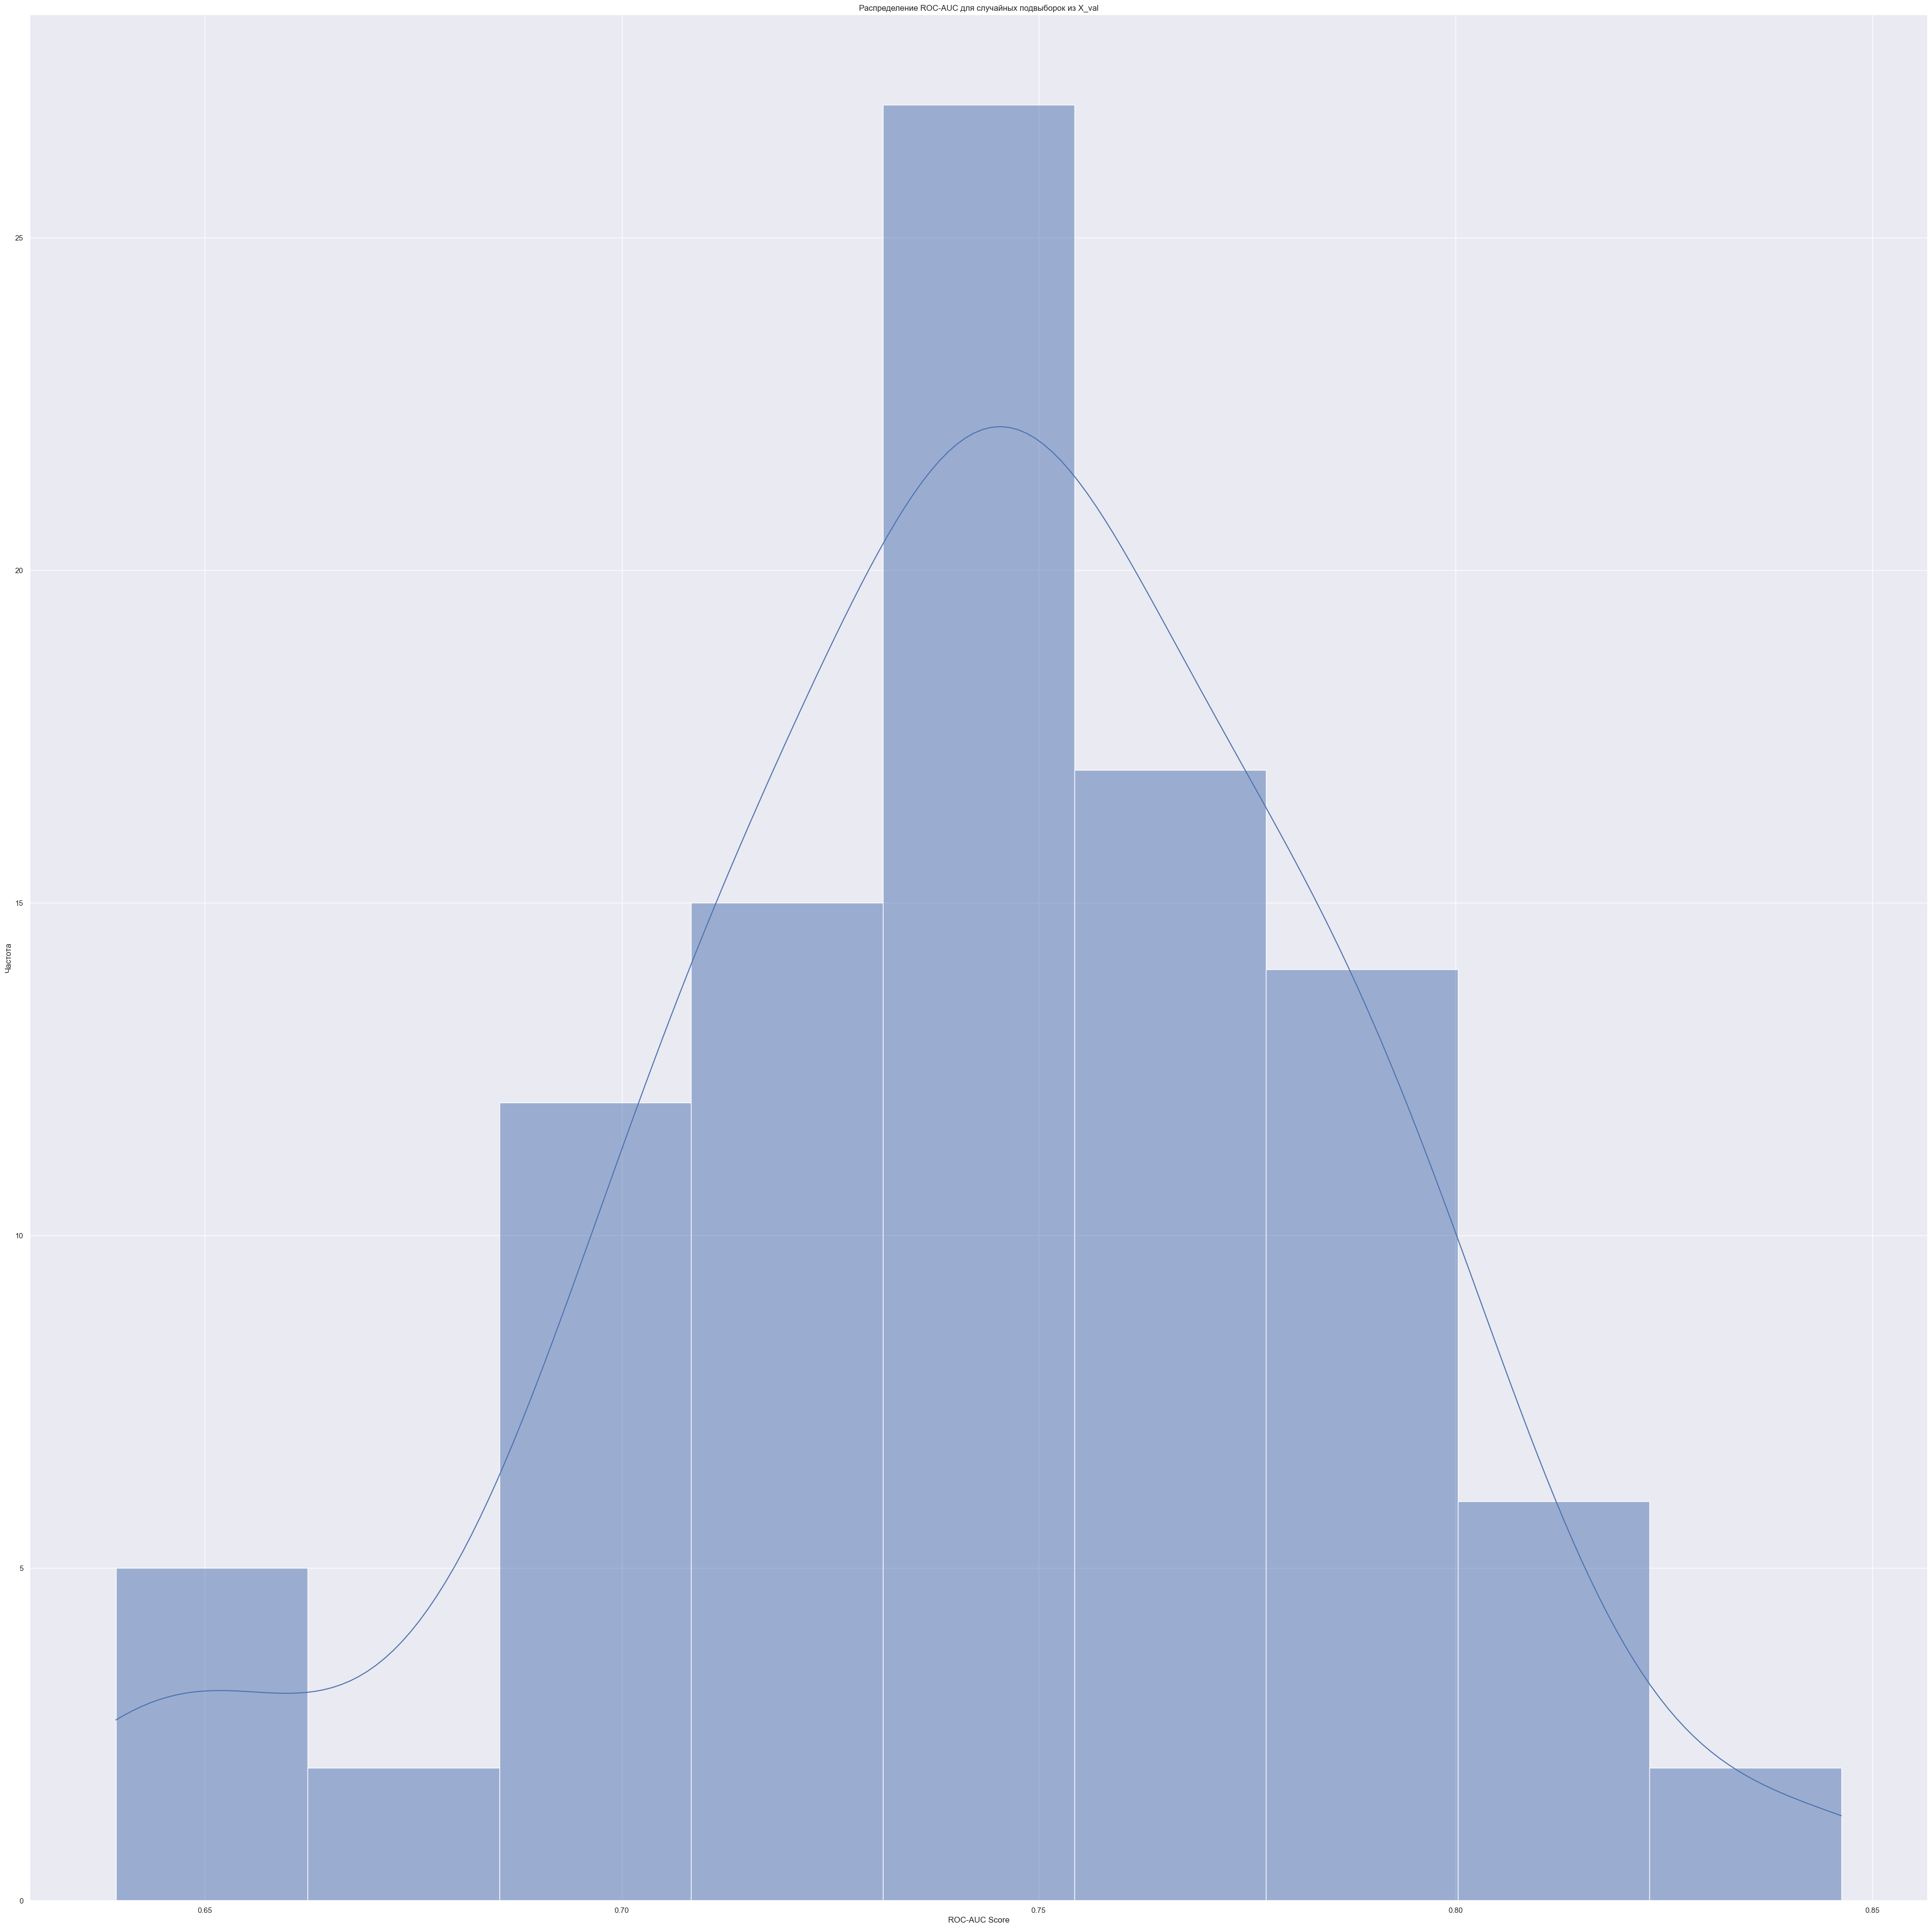

5-й квантиль: 0.6678067010309278
95-й квантиль: 0.8018013387587501


In [71]:
pickle.dump(model, open('model.pkl', 'wb'))

seed = 42
rng = np.random.RandomState(seed)

roc_auc_scores = []

for _ in range(100):  # Повторяем 100 раз
    # Выбираем случайные 1000 элементов из X_val и соответствующие метки y_val с помощью созданного генератора
    sample_indices = rng.choice(X_val.index, size=1000, replace=False)
    X_val_sample = X_val.loc[sample_indices]
    y_val_sample = y_val.loc[sample_indices]
    
    # Выполняем предсказание для выборки
    y_pred_sample = model.predict_proba(X_val_sample)[:, 1]
    
    # Вычисляем roc_auc и добавляем в список
    roc_auc = roc_auc_score(y_val_sample, y_pred_sample)
    roc_auc_scores.append(roc_auc)

# Визуализация распределения roc_auc с помощью гистограммы
sns.histplot(roc_auc_scores, kde=True)
plt.title('Распределение ROC-AUC для случайных подвыборок из X_val')
plt.xlabel('ROC-AUC Score')
plt.ylabel('Частота')
plt.show()

# Вычисление 5-го и 95-го квантилей
quantile_5 = np.percentile(roc_auc_scores, 5)
quantile_95 = np.percentile(roc_auc_scores, 95)

print(f"5-й квантиль: {quantile_5}")
print(f"95-й квантиль: {quantile_95}")